### **KAGGLE - WHATS COOKING?**

----
<br>

<p style="font-weight: 500; color: #556;">This ongoing Kaggle competition serves us a JSON/dict style dataset, with each entry containing a given cuisine type, and within that, a list of ingredients.  The challenge is to classify and predict the cuisine types correctly using the ingredient list given.</p>
<br>

In [787]:
import numpy as np
import pandas as pd
import os
import re
import time
import shutil
import json
import random
import copy
import zipfile
import pickle

import datetime
from datetime import datetime as dt

import tensorflow as tf
from tensorflow.keras.metrics import AUC
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model,save_model,load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import TextVectorization

from itertools import product

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter,defaultdict

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import catboost
from catboost import CatBoostClassifier as cbc,CatBoostRegressor as cbr

AUTOTUNE = tf.data.AUTOTUNE


from helpers import *

In [788]:
sns.set_theme()

VAL_FRAC = 0.1
if 'my_auc' not in globals():
    my_auc = AUC()  # store the AUC method, being sure to only do so once
MODEL_PATH = 'models/'
MODEL_PATH_TEST = 'models_test/'
HISTORY_PATH = 'model_data/model_history.csv'
HISTORY_PATH_TEST = 'model_data/model_history_test.csv'
SEED = 89  # this must remain the same for dataset generation consistency, as pandas uses the numpy seed to dictate its own randomness
VOCAB_SIZE = 10000


# initialize a global store for model histories, and re-fetch its contents whenever required 
def model_history(path=HISTORY_PATH):
    return pd.read_csv(path)

#####
#### **HELPER FUNCTIONS**
<p style="font-weight: 500; color: #556;">These will eventually be moved into our <strong>helpers.py</strong> file.  For now they remain here for easy debugging:</p>

In [789]:
# self-ingestion to get out our python code when regular export fails
def get_raw_python_from_notebook(notebook,python=None):
    if python is None: python=notebook
    with open(notebook+'.ipynb','r') as f:
        rawpy = json.load(f)
    rawpy = [[] if c['source'] == [] else c['source'] for c in rawpy['cells'] if c['cell_type']=='code']
    for r in rawpy:
        r.extend(['\n','\n'])
    raw = [l for r in rawpy for l in r]
    with open(python+'.py', 'w') as f:
        f.write(''.join(raw))
get_raw_python_from_notebook('kaggle-whats-cooking')

In [783]:
def text_clean(c, stopwords = None, flatten_case = True):
    c = re.sub('\s+|\n',' ',c)
    c = re.sub(' \.|"','',c)
    if flatten_case is True:
        c = c.lower()
    if stopwords is not None:
        c = ' '.join([s for s in c.split() if s not in stopwords and len(s) < 50])
    return c.strip()

In [784]:
def make_confusion_matrix(data, *args, percent='precision', preds='pred', real='real', counts=None, groups=None, raw=False):
    if counts is None:
        data['accuracy'] = 1 #np.where(data['pred']==data['real'],1,0)
        counts = 'accuracy'
    
    # fix to allow zero groups to be in here :) 
    permutations = {
        'pred': np.arange(len(set(data['real']))),
        'real': np.arange(len(set(data['real']))),
        counts: [0]
    }
    permutations = pd.DataFrame(product(*[permutations[c] for c in permutations]),columns=permutations.keys())
    data = data.append(permutations).reset_index(drop=True)

    columns = None if 'columns' not in args else columns['args']
    idx = preds if percent=='recall' else real
    col = real if percent=='recall' else preds
    data = data.groupby([preds,real]).sum().reset_index().pivot(index=idx, columns=col, values=counts).fillna(0).reset_index(drop=True)
    # return data
    if groups is not None: data.columns = groups
    for c in data.columns:
        try:
            data[c] = np.round(100*data[c]/max(1e-5,np.sum(data[c])),5)
        except:
            data[c] = 0.
    pretty_data = pretty_pandas(data,configs=make_palette(5,98,palette=['#F7F7FE','#FE0','red'],number='pct',columns=columns))
    return data if raw is True else pretty_data

In [785]:
# legacy method for tokenizing using tf.keras.preprocessing.text.Tokenizer

def text_prepare_legacy(data, stopwords = None, num_words = 10000, oov_token = '<OOV>', max_len = 'max', padding = 'post',
                        val_frac=0.1, chunk_size = 1, encode = None):
    data.columns = ['text','id']+list(data.columns)[2:]
    data['len'] = data['text'].apply(lambda x: len(x.split()))

    max_len = np.max(data['len']) if max_len == 'max' else np.minimum(np.max(data['len']),max_len)

    train = data.drop_duplicates(subset=['text']).reset_index(drop=True)

    label_list = []
    encoder,decoder = {},{}
    for l in list(data.columns)[1:-1]: #-1]:
        if encode == 'ordinal':
            label_list.append(l)
            train[l+'_original'] = train[l]
            #return train[l]
            le = LabelEncoder().fit(train[l])
            for t in list(set(train[l])):
                encoder[t] = le.transform([t])[0]
                decoder[le.transform([t])[0]] = t
            train[l] = le.transform(train[l])
            #return train[l]
        elif encode == 'onehot':
            label_options = [re.sub(' ','_',i) for i in set(train[l])]
            for s in label_options:
                train[l+'_'+s] = [1 if j==s else 0 for j in train[l]]
                label_list.append(l+'_'+s)

    # return list(data.columns)[2:],label_list

    ids = list(train[['id']].drop_duplicates()['id'])
    ids_val = ids[:int(len(ids)*val_frac)]

    val = train[train['id'].isin(ids_val)].reset_index(drop = True)
    train = train[~train['id'].isin(ids_val)].reset_index(drop = True)

    tokenizer = Tokenizer(num_words = num_words,oov_token = oov_token)
    tokenizer.fit_on_texts(train['text'])

    train_sequences = tokenizer.texts_to_sequences(train['text'])
    val_sequences = tokenizer.texts_to_sequences(val['text'])

    train_padded = pad_sequences(train_sequences, maxlen = max_len, padding = padding)
    val_padded = pad_sequences(val_sequences, maxlen = max_len, padding = padding)

    train_labels,val_labels = {},{}
    for l in label_list:
        train_labels[l] = np.array(train[l])
        val_labels[l] = np.array(val[l])

    word_index = tokenizer.word_index

    # here we return a set of assets relevant to the data and its tokenization, for use in modeling later
    return {'train_padded': train_padded,
            'train_labels': train_labels,
            'val_padded': val_padded,
            'val_labels': val_labels,
            'encoder': encoder,
            'decoder': decoder,
            'max_len': max_len,
            'word_index': word_index,
            'vocab': num_words,
            'train': train,
            'val': val}

In [786]:
# new version - using the TextVectorizer layer method

def text_prepare(data, tokenizing_data=None, stopwords = None, num_words = 10000, oov_token = '<OOV>', max_len = 'max', batch_size=None,
                 label = 'last', padding = 'post', val_frac=0.1, chunk_size = 1, encode = None):
    
    if tokenizing_data is None:
        tokenizing_data = data.iloc[:,:]
        
    cols = list(tokenizing_data.columns)
    if label is 'last':
        label = cols[-1]
    else:
        cols.append(cols.pop(cols.index(label)))
        tokenizing_data = tokenizing_data[cols]
    tokenizing_data['len'] = tokenizing_data[cols[0]].apply(lambda x: len(x.split()))
    
    max_len = np.max(tokenizing_data['len']) if max_len == 'max' else np.minimum(np.max(tokenizing_data['len']),max_len)

    tokenizing_train = tokenizing_data.drop_duplicates(subset=[cols[0]]).reset_index(drop=True)
    train = data.drop_duplicates(subset=[cols[0]]).reset_index(drop=True)

    unique_labels = np.unique(np.array(train[label]))
    label_encoding, label_decoding = {},{}
    for i,c in enumerate(unique_labels):
        label_encoding[c] = i
        label_decoding[i] = c
    if encode in ('ordinal', 'onehot'):
        tokenizing_labels = np.asarray(tokenizing_train[label].apply(lambda x: label_encoding[x]))
        labels = np.asarray(train[label].apply(lambda x: label_encoding[x]))
    if encode == 'onehot':
        tokenizing_labels = to_categorical(tokenizing_labels)
        labels = to_categorical(labels)
        
    tokenizing_split = int(val_frac*len(tokenizing_train))
    split = int(val_frac*len(train))
    
    tokenizing_val_x,tokenizing_val_y = np.asarray(tokenizing_train[cols[0]][:tokenizing_split]),tokenizing_labels[:tokenizing_split]
    tokenizing_train_x,tokenizing_train_y = np.asarray(tokenizing_train[cols[0]][tokenizing_split:]),tokenizing_labels[tokenizing_split:]
    val_x,val_y = np.asarray(train[cols[0]][:split]),labels[:split]
    train_x,train_y = np.asarray(train[cols[0]][split:]),labels[split:]
    
    vectorize_layer = TextVectorization(
        # standardize = custom_standardization,
        max_tokens = num_words,
        output_mode = 'int',
        output_sequence_length = int(max_len)
    )
    
    text_ds = tf.data.Dataset.from_tensor_slices(np.asarray(tokenizing_train_x)).batch(64)
    vectorize_layer.adapt(text_ds)

    tokenizing_model = tf.keras.models.Sequential()
    tokenizing_model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
    tokenizing_model.add(vectorize_layer)
    
    train_x = tokenizing_model.predict(train_x,verbose=0)
    val_x = tokenizing_model.predict(val_x,verbose=0)
    
    if encode == 'onehot':
        train = [tf.data.Dataset.from_tensor_slices((train_x,train_y[:,i])) for i in range(len(unique_labels))]
        val = [tf.data.Dataset.from_tensor_slices((val_x,val_y[:,i])) for i in range(len(unique_labels))]
    else:
        train = [tf.data.Dataset.from_tensor_slices((train_x,train_y))]
        val = [tf.data.Dataset.from_tensor_slices((val_x,val_y))]
    
    if batch_size is not None: # batching is useful for speed when we predict (indpendent of batches for training)
        train = [t.batch(batch_size) for t in train]
        val = [v.batch(batch_size) for v in val]
        
    vocab = vectorize_layer.get_vocabulary()
    word_encoding, word_decoding = {}, {}
    for i, w in enumerate(vocab):
        word_encoding[w] = i
        word_decoding[i] = w
        
    # we now return a set of assets relevant to the data and its tokenization, for use in modeling later
    return {'vectorizer': vectorize_layer,
            'train_data': train,
            'train_labels': train_y,
            'val_data': val,
            'val_labels': val_y,
            'word_encoding': word_encoding,
            'word_decoding': word_decoding,
            'label_encoding': label_encoding,
            'label_decoding': label_decoding,
            'max_len': max_len,
            'vocab_size': num_words,
            'input_shape': train_x[0].shape,
            'unique_labels': unique_labels}

In [295]:
# this function creates and maintains a centralized DataFrame of model history, and returns the relevant values for analysis and plotting etc

def make_history(history, model_name, lr, optimizer, batch_size, data_source, loss_name, timestamp, label, epoch, epoch_subset = 1, write = True):
    h = pd.DataFrame.from_dict(history).reset_index()
    h.columns = [re.sub('_[0-9]{1}.*','',c) for c in h.columns]
    h['timestamp'] = timestamp
    h['label'] = label
    if len(h)>1:
        h['epoch'] = h['index']+1
    else:
        h['epoch'] = epoch
    h['data'] = data_source
    h['lr_start'] = lr[0]
    h['lr_end'] = lr[1]
    h['optimizer'] = optimizer
    h['loss_name'] = loss_name
    h['batch_size'] = batch_size
    h['epoch_subset'] = epoch_subset
    h['name'] = model_name
    del h['index']
    return h

    try:
        h = pd.read_csv('model_data/'+name+'.csv').append(h).reset_index(drop=True)
    except:
        pass
    if write is True:
        h.to_csv('model_data/'+name+'.csv',index=False)
    cols = ['data','name','label','loss_name','optimizer','lr_start','lr_end','timestamp','loss',
          'accuracy','val_loss','val_accuracy','lr','epoch','batch_size','epoch_subset']
    if 'val_auc' in h.columns:
        cols+=['auc','val_auc']
    h = h[cols]
    return h

In [296]:
def plot_history_v1(hist,name):
    hist = model_history()
    hist = hist[hist['name'].str.contains(name)].reset_index(drop=True)

    (d1,d2) = (1,2)
    fig,axes = plt.subplots(d1, d2, figsize=(20,6))
    #fig.tight_layout()
    for p in set(hist['label']):
        data = hist[hist['label']==p]
        for i in range(d2): s = sns.lineplot(ax=axes[i].twinx(), x = data['epoch'], y = data['lr'], color='#CCE', linestyle='--')
        s = sns.lineplot(ax=axes[0], x = data['epoch'], y = data['accuracy'])
        s = sns.lineplot(ax=axes[0], x = data['epoch'], y = data['val_accuracy'])
        s = sns.lineplot(ax=axes[1], x = data['epoch'], y = data['loss'])
        s = sns.lineplot(ax=axes[1], x = data['epoch'], y = data['val_loss'])

In [307]:
def plot_history(hist, filters=None, group='name', metrics=['accuracy','loss'], width=2, height=1, tight=False, size=(20,6), val=None, show_lr=True):
    if filters is not None:
        hist = hist[hist['name'].str.contains(filters)].reset_index(drop=True)
    fig,axes = plt.subplots(height, width, figsize=size)
    if tight is True: fig.tight_layout()    
    for l,p in enumerate(set(hist[group])):
        data = hist[hist[group]==p]
        for i,j in enumerate(product(range(height),range(width))):
            if i==len(metrics): break
            idx = i%d2 if val is None else i
            if height > 1:
                s = sns.lineplot(ax=axes[0,j[1]], x = data['epoch'], y = data[metrics[idx]])
                s = sns.lineplot(ax=axes[1,j[1]], x = data['epoch'], y = data['val_'+metrics[idx]])
                if show_lr is True and l==0:
                    s = sns.lineplot(ax=axes[0,j[1]].twinx(), x = data['epoch'], y = data['lr'], color='#CCE', linestyle='--')
                    s = sns.lineplot(ax=axes[1,j[1]].twinx(), x = data['epoch'], y = data['lr'], color='#CCE', linestyle='--') # i%height,i%width
            else:
                s = sns.lineplot(ax=axes[j[1]], x = data['epoch'], y = data[metrics[idx]])
                if val=='overlap': s = sns.lineplot(ax=axes[j[1]], x = data['epoch'], y = data['val_'+metrics[idx]])
                if show_lr is True and l==0: s = sns.lineplot(ax=axes[j[1]].twinx(), x = data['epoch'], y = data['lr'], color='#CCE', linestyle='--')

In [298]:
# model wrapper for catboost classification and regression
def cbc_wrapper(data, target='y', test_frac=0.1, loss_function='MultiClass', verbose=1, eval_metric='Accuracy',
                rounds=1, epochs=200, depth=5, learning_rate=0.01, use_best_model=True):

    types_df = pd.DataFrame(data.dtypes).reset_index().reset_index()
    types_char = types_df[types_df[0]=='object']
    types_float = types_df[types_df[0]=='float64']
    types_int = types_df[types_df[0]=='int64']
    ordcols = list(types_char['index'])+list(types_float['index'])+list(types_int['index'])
    ordindices = list(types_char['level_0'])
    data = data[ordcols]
    data[list(types_char['index'])] = data[list(types_char['index'])].astype(str)

    my_features = data.filter(regex='^(?!'+target+')')
    feature_names = list(my_features.columns.values)

    models, model_paths = [], []
    for i in range(rounds):
        data_shuffled = data.loc[:,:].copy().sample(frac=1)
        x_val = data_shuffled.iloc[:int(len(data_shuffled)*test_frac),:]
        y_val = x_val.pop(target)
        x_train = data_shuffled.iloc[int(len(data_shuffled)*test_frac):,:]
        y_train = x_train.pop(target)
        cat_features=list(range(0,len(ordindices)-0))

        model = cbc(loss_function=loss_function,verbose=verbose,eval_metric=eval_metric,metric_period=1,
                          iterations=epochs,depth=depth,learning_rate=learning_rate,od_wait=20)
        model.fit(x_train,y_train,eval_set=(x_val,y_val),cat_features=cat_features,metric_period=1)
        y_pred = model.predict(x_val,verbose=verbose)
        
        res = model.evals_result_
        for m,k in enumerate(res.keys()):
            for j,l in enumerate(res[k].keys()):
                if m==0 and j==0:
                    history = pd.DataFrame(res[k][l],columns=[(k+'_'+l).lower()]).reset_index()
                else:
                    history = pd.concat([history,pd.DataFrame(res[k][l],columns=[(k+'_'+l).lower()]).reset_index(drop=True)],axis=1)
        history.columns = ['epoch']+list(history.columns)[1:]
        history['depth'] = depth
        history['learning_rate'] = learning_rate
        history['max_epochs'] = epochs
        history['rounds'] = rounds
        history['round'] = i+1
        if type == 'regressor':
            r2 = r2_score(np.array(y_val),y_pred)
            history['r2'] = np.round(r2,6)
        history_all = history if i==0 else history_all.append(history) 

        models.append(model)
    
    if rounds==1: models = models[-1]
    params = {'x_train': x_train,
              'y_train': y_train,
              'x_val': x_val,
              'y_val': y_val,
              'cat_features': cat_features,
              'y_pred': y_pred}
        
    return models,history_all,params

In [299]:
# model wrapper for fully connected model architectures 

def embedding_model(input_length, embedding_dim=16, vocab_size=VOCAB_SIZE, categories=1, lr=1e-3, dense_layers=[256], metrics=['accuracy']):

    if categories >= 2:
        loss = tf.keras.losses.SparseCategoricalCrossentropy()
        output_activation='softmax'
    else:
        loss = tf.keras.losses.BinaryCrossentropy()
        output_activation='sigmoid'
    
    input_layer = tf.keras.Input(shape=input_length)
    x = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=input_length)(input_layer)
    x = tf.keras.layers.Flatten()(x)
    for l in dense_layers:
        x = tf.keras.layers.Dense(l, activation='relu')(x)
    output_layer = tf.keras.layers.Dense(categories, activation=output_activation)(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    
    # setup the training parameters
    model.compile(loss=loss,
                  optimizer=tf.keras.optimizers.Adam(lr=lr),
                  metrics=metrics)

    return model

In [300]:
# model wrapper for LSTM returrant NN architectures - these are works in progress

def lstm_model(data, loss = 'binary_crossentropy', optimizer = 'adam', rnn_depth = 64, embedding_dim = 16, layer_norm = False,
               categories = 1, activation = 'sigmoid', metrics=['accuracy']):
    input_layer = tf.keras.Input(shape = data['input_shape'])
    x = tf.keras.layers.Embedding(data['vocab_size'], embedding_dim, input_length = data['max_len'])(input_layer)
    # x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(rnn_depth,))(x)
    if layer_norm is True: x = tf.keras.layers.LayerNormalization()(x) # experimental!
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    output_layer = tf.keras.layers.Dense(categories, activation)(x)
    model = Model(inputs = input_layer, outputs = output_layer)
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)
    return model

In [301]:
# stateful version of LSTM model wrapper - work in progress - bidirectional stateful to fix

class lstm_model_stateful(tf.keras.Model):
    def __init__(self, data, rnn_units, embedding_dim = 16):
        super().__init__(self)
        self.input_layer = tf.keras.Input(shape = data['input_shape'])
        self.embedding = tf.keras.layers.Embedding(data['vocab_size'], embedding_dim, input_length = data['max_len'])
        self.lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(rnn_units, return_sequences=False, return_state=True))
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, states=None, return_state=False, training=False):
        x = inputs
        x = self.embedding(x, training=training)
        #if states is None:
        #    states = self.lstm.get_initial_state(x)
        #return self.lstm(x, initial_state=states, training=training)
        
        x, state1, state2, state3, state4 = self.lstm(x, initial_state=states, training=training)
        x = self.dense(x, training=training)

        if return_state:
            return x, [state1, state2, state3, state4]
        else:
            return x

In [302]:
def model_gen(data): # to be expanded for different model types
    return lstm_model(data, loss = 'sparse_categorical_crossentropy', optimizer = 'adam',
                      rnn_depth = 64, embedding_dim = 16, layer_norm = False, categories = 20,
                      activation = 'softmax', metrics=['accuracy'])

In [303]:
def learning_trajectory(epochs, lr=(1e-5, 1e-3), mode='linear', return_list=False):
    # modes can be linear, exponential, (plateau...?)
    if mode == 'linear':
        lr_list = [LearningRateScheduler(lambda epoch: lr[0] + ((lr[1]-lr[0])*epoch/epochs))]
        if return_list is True:
            return [lr[0] + ((lr[1]-lr[0])*epoch/epochs) for epoch in range(epochs)]
    elif (mode == 'exp') or (mode == 'exponential'):
        lr_list = [LearningRateScheduler(lambda epoch: lr[0] * 10**(np.log10(lr[1]/lr[0])*(epoch)/(epochs-1)))]
        if return_list is True:
            return [lr[0] * 10**(np.log10(lr[1]/lr[0])*(epoch)/(epochs-1)) for epoch in range(epochs)]
    return lr_list

In [304]:
def model_wrapper_legacy(data, label = 'y', model_name = 'mymodel', lr = (5e-5,1e-3), epochs = 1, split_epochs = False, start = 1, end = None, batch_size = 128,
                      epoch_subset = 1, epoch_subset_val = 1, complete_all_subsets = True, history = 'model_history', class_weight = None, rnn_depth = 64,
                      embedding_dim = 16, layer_norm = False, multiclass = False, save_freq = 1, save_format = 'savedmodel', stop = None):

    ## to do: implement early stopping when we split the epochs
    ## to do: make the early stopping dynamic in relation to the learning rate (intuition seen from other projects)
    ## implement regularization parameters
    ## to do: make this into a class-based architecture
    
    if split_epochs is True:
        runs = epochs
        epochs = 1
    else:
        runs = 1 if complete_all_subsets is False else int(1/epoch_subset)
    end = min(runs, start + end) if end is not None else runs

    if multiclass is True:
        loss_name = 'sparse_categorical_crossentropy' # tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        optimizer = 'adam'
        activation = 'softmax'
        categories = len(set(data['train_labels'][label]))
        monitor_metric = 'val_accuracy'
        metrics = ['accuracy']
    else: 
        loss_name = 'binary_crossentropy' # tf.keras.losses.BinaryCrossentropy()
        optimizer = 'adam'
        activation = 'sigmoid'
        categories = 1
        monitor_metric = 'val_auc'
        metrics = ['accuracy',AUC]

    try:
        model_data = pd.read_csv('model_data/'+history+'.csv')
        model_data = model_data[model_data['name'] == model_name]       
        start = max(model_data['epoch'])+1
        print(start)
        if start > max(runs,epochs): return
        best = max(model_data[monitor_metric])
        models = [load_model('model_data/'+model_name+'_last')]
    except:
        model_data = None
        print('no model found - initializing')
        best = 0.0
        models = [lstm_model(data, loss_name, optimizer, rnn_depth, embedding_dim, layer_norm, categories, activation, metrics)]

    data_source = 'kaggle_whats_cooking'
    r = start
    timestamp = dt.strftime(dt.now(),'%Y-%m-%d %H:%M:%S')
    metric_history = [0]

    # checkpoint = ModelCheckpoint(
    #     'model_data/'+model_name+'_best',
    #     monitor = monitor_metric,
    #     verbose = 0,
    #     mode = 'max',
    #     save_best_only = True
    # )

    stop_early = EarlyStopping(monitor = 'val_loss', patience = stop, restore_best_weights = True)

    if class_weight is not None:
        class_sizes = pd.DataFrame.from_dict([Counter(data['train_labels'][label])]).transpose()
        class_weight = {}
        for l in set(data['train_labels'][label]):
            class_weight[l] = 1/class_sizes[0][l]

    while r <= min(end,runs):
        if (r > 1):
            if (r%save_freq == 1 or save_freq == 1):
                models = [load_model('model_data/'+model_name+'_last')]
                metric_history = [0]
            else:
                models.append(copy.copy(models[-1]))

        lr_scheduler = LearningRateScheduler(
            lambda epoch: lr[0] * 10**(np.log10(lr[1]/lr[0])*(max(r,epoch+1)-1)/max(1,epochs-1,runs-1))
        )

        np.random.seed(np.random.randint(1e6))
        mylen = data['train_padded'].shape[0]
        # subset = np.random.choice(mylen, int(mylen*epoch_subset), replace=False)
        subset = np.arange(int(mylen*epoch_subset*((r-1)%runs)),min(mylen,int(mylen*epoch_subset*(r%runs))))
        x = data['train_padded'][subset]
        y = data['train_labels'][label][subset]
        
        np.random.seed(480)
        mylen_val = data['val_padded'].shape[0]
        subset_val = np.random.choice(mylen_val, int(mylen_val*epoch_subset_val), replace=False)
        x_val = data['val_padded'][subset_val]
        y_val = data['val_labels'][label][subset_val]

        print(models[-1].summary)
        h = models[-1].fit(
            x,y,
            batch_size = batch_size,
            epochs = epochs,
            validation_data = (x_val,y_val), #(data['val_padded'],data['val_labels'][label]),
            callbacks = [lr_scheduler,stop_early],
            class_weight = class_weight
        )

        if np.isclose([h.history[monitor_metric][-1:]],[0.5000]):
            if r == 1:
                models[-1] = lstm_model(data, loss_name, optimizer, rnn_depth, embedding_dim, layer_norm, categories, activation, metrics)
            else:
                models[-1] = load_model('model_data/'+model_name+'_last')
        else:
            metric_history.append(h.history[monitor_metric][-1:][0])
            full_history = make_history(h, model_name, lr, optimizer, batch_size, data_source, loss_name, timestamp,
                                        label, epoch = r, epoch_subset = epoch_subset, name = history)
            
            full_history = np.array(full_history[full_history['name'] == model_name][monitor_metric])
            
            if split_epochs is False:
                save_model(models[-1],'model_data/'+model_name+'_last')
            elif r%save_freq == 0:
                best = max(full_history)
                save_model(models[-1],'model_data/'+model_name+'_last')
                print('last model saved')
                if max(metric_history) >= best:
                    shutil.copytree('model_data/'+model_name+'_last','model_data/'+model_name+'_best',dirs_exist_ok=True)
                    print('best model saved')
            r += 1
            
        # let's catch the early stopping rule here
        if (len(full_history) > stop) and (np.argmax(full_history)<(len(full_history)-stop)):
            return

In [305]:
# this function provides a wrapper to train models either in one go, or incrementally by epoch, tracking progress
# the notion was established to tackle the fact that many models would crash before they finished training as they are very heavy

def process_model(data, model, label = 'y', model_name = 'mymodel', model_selection = 'lstm', lr = (5e-5,1e-3), epochs = 1, split_epochs = False,
                start = 1, end = None, batch_size = 128, epoch_subset = 1, epoch_subset_val = 1, complete_all_subsets = True, model_path = MODEL_PATH,
                history_path = HISTORY_PATH, class_weight = None, optimizer = None, loss_name = None, rnn_depth = 64, embedding_dim = 16,
                layer_norm = False, multiclass = True, label_class = 0, save_format = 'savedmodel', stop_early = True, verbose = False):
    
    # split_epochs allows us save the model after *every* epoch, and resume from the reloaded
    # version if necessary. This failsafes against model crashes when they are heavy
    if split_epochs is True:
        runs = epochs
        epochs = 1
    else:
        runs = 1
    end = min(runs, start + end) if end is not None else runs   
    
    # some parameters to store and monitor results
    data_source = 'kaggle_whats_cooking'
    stop_early = 5 if stop_early is True else stop_early
    timestamp = dt.strftime(dt.now(),'%Y-%m-%d %H:%M:%S')
    monitor_metric = 'val_auc' if multiclass is False else 'val_accuracy'
    lr_mode = lr[-1] if len(lr)>2 else 'exp' # default learning rate mode to exponential if we didn't set one
    
    try: # check if we already have a model history file in general
        model_data_all = pd.read_csv(history_path)
    except:
        model_data_all = None
        
    try: # check if any existing model history file contains history of the current model 
        model_data = model_data_all[model_data_all['name'] == model_name]     
        start = max(model_data['epoch'])+1
        if verbose is True: print(start)
        if start > max(runs,epochs): return # this means we've already completed our epochs and didn't need any further runs
        metric_history = [max(model_data[monitor_metric])] # a record of the model performance for each epoch, if they render separate models
        model = load_model('model_data_test/'+model_name+'_last') # load most recent completed epoch of the model
    except: # if we have not got the model in our history, we start from scratch
        if verbose is True: print('no model found - initializing')
        metric_history = [0]
        # return a compiled model with requested parameters
            # model = model_gen(data) # model, multiclass, rnn_depth, embedding_dim, layer_norm, categories, activation, metrics)]
            # model = model

    r = start # which epoch we start from
    
    # set up model callbacks - we need a set of learning rates as a list to apply to our iterator
    learning_rate_list = learning_trajectory(max(runs,epochs), lr = lr, mode = lr_mode, return_list = True)
    early_stopping = EarlyStopping(monitor = monitor_metric, patience = stop_early, restore_best_weights = True)
    
    # set optional class weights to tackle imbalance if we wish 
    if class_weight is not None:
        class_sizes = pd.DataFrame.from_dict([Counter(data['train_labels'])]).transpose()
        class_weight = {}
        for l in set(data['train_labels']): # [label]
            class_weight[l] = min(class_sizes[0])/class_sizes[0][l]
            
    # batch and optimize our train and validation data
    train_data = data['train_data'][label_class]
    val_data = data['val_data'][label_class]
    
    try:
        train_data = train_data.unbatch()
        val_data = val_data.unbatch()
    except:
        pass
    
    train_data = train_data.cache().batch(batch_size).shuffle(1000).prefetch(buffer_size = AUTOTUNE)
    val_data = val_data.cache().batch(batch_size).shuffle(1000).prefetch(buffer_size = AUTOTUNE)
    
    while r <= min(end, runs):
        # the models are always stored in an array. This just has length 1 if we didnt set split_epochs to true. Else, it accumulates per epoch
        learning_rate = (learning_rate_list[r-1], learning_rate_list[r-1]) if split_epochs is True else lr
        learning_rates = learning_trajectory(max(runs,epochs), lr = learning_rate, mode = 'exp', return_list = False)
        callbacks = [learning_rates]
        if (split_epochs is False) and (stop_early is not False): callbacks.append(early_stopping)
        
        h = model.fit(
            train_data,
            batch_size = batch_size,
            epochs = epochs,
            validation_data = val_data,
            callbacks = callbacks,
            class_weight = class_weight
        ).history
        
        history = make_history(h, model_name, lr, optimizer, batch_size, data_source, loss_name,
                               timestamp, label, epoch = r, epoch_subset = epoch_subset)
        try:
            model_data_all = model_data_all.append(history)
        except:
            model_data_all = history
        model_data_all.to_csv(history_path,index=False)
        metric_history.append(h[monitor_metric][-1:][0]) # add most recent model performance metric to the history to compare
        
        tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
        save_model(model,model_path+model_name+'_last'+('.h5' if save_format=='h5' else ''))
        
        if split_epochs is True:
            if verbose is True: print('last model saved')
            if np.argmax(np.flip(metric_history)) == 0: # if the most recent epoch was the best, the argmax of the flip will always be 0
                # store the last model as the best if appropriate
                shutil.copytree(model_path+model_name+'_last', model_path+model_name+'_best', dirs_exist_ok=True)
                if verbose is True: print('best model saved')
            elif (stop_early is not False) and (np.argmax(np.flip(metric_history)) >= stop_early): # early stopping for the split epoch case
                break
        r += 1

####
#### **READ IN AND EXPLORE DATA**

<p style="font-weight: 500; color: #556;">Our raw data is in JSON format, so let's read it in and parse it to a DataFrame:</p>

In [321]:
with open('data/train.json','r') as f: train = json.load(f)
with open('data/test.json','r') as f: test = json.load(f)

In [322]:
np.random.seed(SEED)
train_df = pd.DataFrame.from_dict(train).sample(frac=1).reset_index(drop=True)
test_df = pd.DataFrame.from_dict(test)

train_df.head()

,id,cuisine,ingredients
0,21245,chinese,"[soy sauce, sesame oil, garlic cloves, boneles..."
1,23955,mexican,"[pepper, 2% reduced-fat milk, enchilada sauce,..."
2,27751,greek,"[fresh dill, dry white wine, dill tips, ground..."
3,27929,mexican,"[chili powder, cumin, garlic powder, all-purpo..."
4,25449,indian,"[cauliflower, yoghurt, teas, white pepper]"


In [379]:
cuisine_groups = np.unique(train_df['cuisine'])

In [323]:
groups_df = pd.DataFrame.from_dict([Counter(train_df['cuisine'])]).transpose().reset_index().sort_values(by='index').reset_index(drop=True)
groups_df['share'] = (groups_df[0]/sum(groups_df[0])).apply(lambda x: '{0:.2%}'.format(x))
groups_df

,index,0,share
0,brazilian,467,1.17%
1,british,804,2.02%
2,cajun_creole,1546,3.89%
3,chinese,2673,6.72%
4,filipino,755,1.90%
5,french,2646,6.65%
6,greek,1175,2.95%
7,indian,3003,7.55%
8,irish,667,1.68%
9,italian,7838,19.71%


<p style="font-weight: 500; color: #556;">We can see that the data is rather unbalanced.  This is not necessarily a problem but we may need to ad just the class weights when modelling, to account for this difference.  The number of total classes will also play a role here, as a single multiclass classifier will be faster, but may be less predictive that a set of binary "one-vs-rest" models.</p>

####

#### **A BASELINE STRUCTURED DATA APPROACH?**


<p style="font-weight: 500; color: #556;">As a baseline method, we can look at the results we'd get from just treating this as a structured data problem, not attempting to use any kind of embedding, sequence model or factoring in the relationships between ingredients.  This approach would be expected to give only average results at best, given our high dimensionality.</p>

In [12]:
foods = [] # get an exhaustive list of foods contained in recipes
for i in train:
    foods = foods+i['ingredients']

In [31]:
food_counts = Counter(foods) # get the frequencies of each food to aid prioritization

food_counts = pd.DataFrame.from_dict([food_counts]).transpose().reset_index()
food_counts.columns = ['food','freq']
food_counts = food_counts.sort_values(by='freq',ascending=False).reset_index(drop=True)
food_counts['cum_sum'] = np.cumsum(food_counts['freq'])/sum(food_counts['freq'])
print('Total number of foods:',len(food_counts),'\n')
food_counts.head()

Total number of foods: 6714 



,food,freq,cum_sum
0,salt,18049,0.042143
1,olive oil,7972,0.060758
2,onions,7972,0.079372
3,water,7457,0.096784
4,garlic,7380,0.114016


<p style="font-weight: 500; color: #556;">Now we can expand the list of foods as one-hot columns, in their order of frequency, which will give us a very large dataframe from which to train:</p>

In [36]:
for i,j in enumerate(food_counts['food'][:len(food_counts)]):
    if i%200 == 0: print(i)
    train_df[j] = train_df['ingredients'].apply(lambda x: 1 if j in x else 0)
    test_df[j] = test_df['ingredients'].apply(lambda x: 1 if j in x else 0)

In [33]:
train_df.head()

,id,cuisine,ingredients,salt,olive oil,onions,water,garlic,sugar,garlic cloves,...,whole garam masala,rose hip tea bags,small potatoes,cherry syrup,frozen fruit,sauerkraut juice,no-calorie sweetener,Bob Evans Italian Sausage,extra firm silken tofu,crushed cheese crackers
0,21245,chinese,"[soy sauce, sesame oil, garlic cloves, boneles...",0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,23955,mexican,"[pepper, 2% reduced-fat milk, enchilada sauce,...",1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,27751,greek,"[fresh dill, dry white wine, dill tips, ground...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,27929,mexican,"[chili powder, cumin, garlic powder, all-purpo...",1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,25449,indian,"[cauliflower, yoghurt, teas, white pepper]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#####
<p style="font-weight: 500; color: #556;">We have a lot of features here, so let's use PCA to determine how many of them we ought to keep:</p>

In [34]:
pca = PCA().fit(train_df.iloc[:,3:])

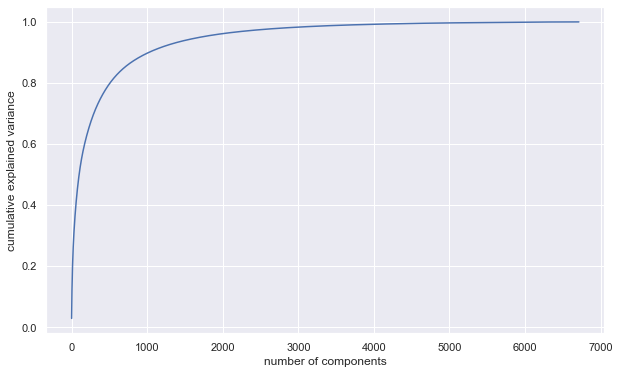

In [35]:
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

#####
<p style="font-weight: 500; color: #556;">Clearly, we'ere better the more we retain, but even 250 ingredients retains 70% of the total detail, with 1000 giving as much as 90%.  We neen't go further than 1,000 here, given the expectation of slower training times and diminishing gains</p>

In [37]:
pca = PCA(n_components=250).fit(train_df.iloc[:,3:])

In [52]:
x_train = pca.transform(train_df.iloc[:,3:])
y_train_ordinal = LabelEncoder().fit(train_df['cuisine']).transform(train_df['cuisine'])
y_train_one_hot = OneHotEncoder().fit(np.array(train_df['cuisine']).reshape(-1, 1)).transform(np.array(train_df['cuisine']).reshape(-1, 1)).toarray()

In [53]:
data_ordinal = pd.concat([pd.DataFrame(x_train),pd.DataFrame(y_train_ordinal)],axis=1)

In [54]:
data_ordinal.columns = list(data_ordinal.columns)[:-1]+['y']
data_ordinal.head()

,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,y
0,-0.793756,-0.011495,0.346442,0.893904,0.627477,-0.139058,0.770465,-0.701342,0.386110,0.099747,...,0.086575,0.104906,-0.007960,0.037408,-0.047109,0.024010,-0.071784,-0.086905,-0.055225,3
1,0.931823,0.149149,0.029087,-0.285085,-0.771494,-0.302789,0.010554,-0.375788,-0.106556,0.222542,...,0.011238,-0.078865,-0.050562,0.004878,-0.062396,-0.017213,0.008934,-0.080315,0.000958,13
2,-0.409377,-0.261780,-0.504056,-0.047728,0.114650,-0.012896,0.162425,0.653060,0.018836,-0.425013,...,0.041020,-0.035892,0.005705,0.026626,-0.017994,-0.019129,0.112770,-0.040870,0.002973,6
3,0.376471,0.561415,-0.147188,-0.209424,-0.115437,-0.371166,-0.030126,0.207802,-0.264860,0.406749,...,-0.007937,-0.011482,0.124897,0.068071,0.034693,0.010434,0.014222,-0.026389,0.047623,13
4,-0.586076,-0.027806,-0.089380,-0.137770,-0.083863,-0.215188,-0.230432,-0.058972,-0.016745,-0.127832,...,0.009607,0.030984,-0.094096,0.147379,0.027669,0.008683,-0.000051,0.027420,0.047537,7


#####
<p style="font-weight: 500; color: #556;">Now let's fit the model using our <strong>CatBoost</strong> helper function:</p>

In [214]:
model1,model_history1,model_data1 = cbc_wrapper(data_ordinal,epochs=20000,verbose=1000,eval_metric='Accuracy')
model1.save_model('models/catboost_1.json',format='json')
model_history1.to_csv('models/catboost_history_1.csv',index=False)

In [206]:
model2,model_history2,model_data2 = cbc_wrapper(data_ordinal,epochs=20000,verbose=1000,eval_metric='MultiClass')
model2.save_model('models/catboost_1.json',format='json')
model_history2.to_csv('models/catboost_history_2.csv',index=False)

0:	learn: 2.9692773	test: 2.9689544	best: 2.9689544 (0)	total: 191ms	remaining: 1h 3m 31s
1000:	learn: 1.3841966	test: 1.4472240	best: 1.4472240 (1000)	total: 3m 39s	remaining: 1h 9m 34s
2000:	learn: 1.0966416	test: 1.2247863	best: 1.2247863 (2000)	total: 7m 16s	remaining: 1h 5m 27s
3000:	learn: 0.9511966	test: 1.1354476	best: 1.1354476 (3000)	total: 10m 55s	remaining: 1h 1m 52s
4000:	learn: 0.8611151	test: 1.0888266	best: 1.0888266 (4000)	total: 14m 36s	remaining: 58m 26s
5000:	learn: 0.7917354	test: 1.0570183	best: 1.0570183 (5000)	total: 18m 14s	remaining: 54m 42s
6000:	learn: 0.7364615	test: 1.0348398	best: 1.0348398 (6000)	total: 21m 55s	remaining: 51m 8s
7000:	learn: 0.6891690	test: 1.0175094	best: 1.0175094 (7000)	total: 25m 45s	remaining: 47m 49s
8000:	learn: 0.6480439	test: 1.0036188	best: 1.0036188 (8000)	total: 29m 29s	remaining: 44m 14s
9000:	learn: 0.6108274	test: 0.9921166	best: 0.9921166 (9000)	total: 33m 21s	remaining: 40m 45s
10000:	learn: 0.5759489	test: 0.9819618	bes

In [312]:
model_history_all = pd.concat([model_history2.iloc[:,:3],model_history1[['learn_accuracy','validation_accuracy']]],axis=1)
model_history_all.columns = ['epoch','loss','val_loss','accuracy','val_accuracy']

In [315]:
model_history_all

,epoch,loss,val_loss,accuracy,val_accuracy
0,0,2.969277,2.968954,0.342515,0.333920
1,1,2.943763,2.944177,0.364248,0.352778
2,2,2.919730,2.920443,0.381596,0.363339
3,3,2.897624,2.898213,0.391038,0.373397
4,4,2.875296,2.875772,0.396402,0.377923
...,...,...,...,...,...
15002,15002,0.435492,0.951325,NaN,NaN
15003,15003,0.435475,0.951327,NaN,NaN
15004,15004,0.435441,0.951327,NaN,NaN
15005,15005,0.435422,0.951330,NaN,NaN


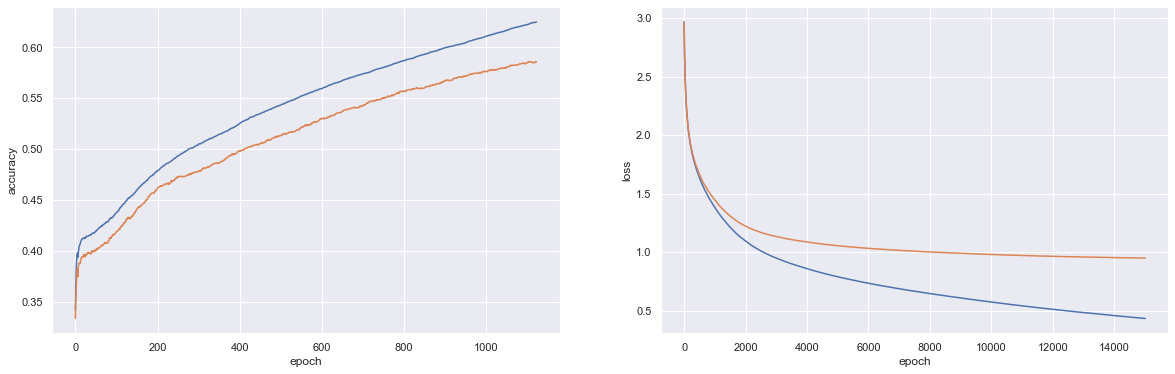

In [313]:
fig,axes = plt.subplots(1, 2, figsize=(20,6))
s = sns.lineplot(ax=axes[0], x = model_history_all['epoch'], y = model_history_all['accuracy'])
s = sns.lineplot(ax=axes[0], x = model_history_all['epoch'], y = model_history_all['val_accuracy'])
s = sns.lineplot(ax=axes[1], x = model_history_all['epoch'], y = model_history_all['loss'])
s = sns.lineplot(ax=axes[1], x = model_history_all['epoch'], y = model_history_all['val_loss'])

<p style="font-weight: 500; color: #556;">Let's check our accuracy scores from the models we produced:</p>

In [251]:
preds1 = pd.concat([pd.DataFrame(model_data1['y_pred']).reset_index(drop=True),pd.DataFrame(model_data1['y_val']).reset_index(drop=True)],axis=1)
preds2 = pd.concat([pd.DataFrame(model_data2['y_pred']).reset_index(drop=True),pd.DataFrame(model_data2['y_val']).reset_index(drop=True)],axis=1)

In [252]:
preds1['match'] = preds1.apply(lambda r: 1 if r['y']==r[0] else 0,axis=1)
preds2['match'] = preds2.apply(lambda r: 1 if r['y']==r[0] else 0,axis=1)

In [256]:
print('Accuracy after',len(model_history1),'epochs is:',sum(preds1['match'])/len(preds1))
print('Accuracy after',len(model_history2),'epochs is:',sum(preds2['match'])/len(preds2))

Accuracy after 1124 epochs is: 0.5861201910988182
Accuracy after 15007 epochs is: 0.7211465929092281


#####
<p style="font-weight: 500; color: #556;">72.1 percent is perhaps better than expected for this use case! A very nice benchmark. The dimensionality is very high and sparse, and required a very high number of epochs to train well, but it made consistent progress for a full 15,000 epochs.</p>
<p style="font-weight: 500; color: #556;">We could try bringing more features back and train the model very slowly, though there are likely better techniques for handling the data, as we'll pursue below:<br><br><br></p>

----

####
#### **USING WORD EMBEDDINGS**

<p style="font-weight: 500; color: #556;">We can now try concatenating the ingredients into a single string/sentence, and tackle the problem using optimized word embeddings and fully connected layers.  Some additional data preparation is required here:</p>

In [324]:
# ADDITIONAL DATA PREPARATION
# concatenate the words into a single string, and clean out any unwanted characters

train_df['recipe_concat'] = train_df['ingredients'].apply(lambda x: ' '.join(x))
train_df['recipe_clean'] = train_df['recipe_concat'].apply(lambda x: text_clean(x))
check_dupes = train_df[['cuisine', 'recipe_concat']].groupby('recipe_concat').count().reset_index()
check_dupes = check_dupes[check_dupes['cuisine']==1]
train_df = train_df[train_df['recipe_concat'].isin(check_dupes['recipe_concat'])].reset_index(drop=True)
train_df.head()

,id,cuisine,ingredients,recipe_concat,recipe_clean
0,21245,chinese,"[soy sauce, sesame oil, garlic cloves, boneles...",soy sauce sesame oil garlic cloves boneless sk...,soy sauce sesame oil garlic cloves boneless sk...
1,23955,mexican,"[pepper, 2% reduced-fat milk, enchilada sauce,...",pepper 2% reduced-fat milk enchilada sauce oni...,pepper 2% reduced-fat milk enchilada sauce oni...
2,27751,greek,"[fresh dill, dry white wine, dill tips, ground...",fresh dill dry white wine dill tips ground bla...,fresh dill dry white wine dill tips ground bla...
3,27929,mexican,"[chili powder, cumin, garlic powder, all-purpo...",chili powder cumin garlic powder all-purpose f...,chili powder cumin garlic powder all-purpose f...
4,25449,indian,"[cauliflower, yoghurt, teas, white pepper]",cauliflower yoghurt teas white pepper,cauliflower yoghurt teas white pepper


In [325]:
model_data_legacy = text_prepare_legacy(train_df[['recipe_clean','cuisine']], num_words = VOCAB_SIZE, max_len = 30, encode = 'ordinal')
model_data_onehot_legacy = text_prepare_legacy(train_df[['recipe_clean','cuisine']], num_words = VOCAB_SIZE, max_len = 30, encode = 'onehot')

In [484]:
model_data = text_prepare(train_df[['recipe_clean','cuisine']], num_words = VOCAB_SIZE, max_len = 30, encode = 'ordinal')
model_data_onehot = text_prepare(train_df[['recipe_clean','cuisine']], num_words = VOCAB_SIZE, max_len = 30, encode = 'onehot', batch_size = 32)

####
#### **CLASSIFICATION USING EMBEDDINGS AND A FULLY CONNECTED DNN**

<p style="font-weight: 500; color: #556;">We will now look at the technique of word embeddings as an alternative to the heavy computation involved in PCA.  For this, we'll use teh TensorFlow framework to allow us to customize out models more, take advantage of different tuning techniues and be able to trainmodels incrementally</p>

In [605]:
# model wrapper for fully connected model architectures 

def embedding_model(input_length, embedding_dim=16, vocab_size=VOCAB_SIZE, categories=1, lr=1e-3, dense_layers=[256], metrics=['accuracy']):

    if categories >= 3:
        loss = tf.keras.losses.SparseCategoricalCrossentropy()
        output_activation='softmax'
    else:
        loss = tf.keras.losses.BinaryCrossentropy()
        output_activation='sigmoid'
        
    if type(dense_layers) is not list: # we pass a string to the function to help with pandas sorting, then coerce back to list later
        dense_layers = [int(i) for i in dense_layers.split(',')]
    
    input_layer = tf.keras.Input(shape=input_length)
    x = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=input_length)(input_layer)
    x = tf.keras.layers.Flatten()(x)
    for l in dense_layers:
        x = tf.keras.layers.Dense(l, activation='relu')(x)
    output_layer = tf.keras.layers.Dense(categories, activation=output_activation)(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    
    # setup the training parameters
    model.compile(loss=loss,
                  optimizer=tf.keras.optimizers.Adam(lr=lr),
                  metrics=metrics)

    return model

#####
<p style="font-weight: 500; color: #556;">First we'll try the multiclass case, ordinally encoded for our 20 cuisine groups:</p>

In [638]:
train_data = model_data['train_data'][0].batch(64)
val_data = model_data['val_data'][0].batch(64)

In [639]:
train_shape = iter(train_data).next()[0].shape # verify the length of our tokenized strings. Here, we've used 30
token_length = train_shape[1]

#####
<p style="font-weight: 500; color: #556;">Let's try a few different hyperparameters to see how they perform.  Later on we will see look to tune these more formally bot for now we can iterate a few cases from simple lists:</p>

In [640]:
hyperparams = {
    'learning_rate': [1e-3,1e-4,1e-5],
    'embedding_dim': [16,64],
    'dense_layers': ['256','256,256']
}

In [641]:
def gen_hypers(params, continuous = None, limit = 150, frac=1, keep_sorted=True):
    hypers = pd.DataFrame(product(*[params[c] for c in params]),columns=params.keys())
    hypers = hypers.sample(frac=frac).reset_index(drop=True)
    hypers = hypers[:limit]
    if keep_sorted is True:
        hypers = hypers.sort_values(by=list(hypers.columns),ascending=[True for c in hypers.columns]).reset_index(drop=True)
    return hypers

In [642]:
hyperparams_df = gen_hypers(hyperparams)
hyperparams_df

,learning_rate,embedding_dim,dense_layers
0,0.00001,16,256
1,0.00001,16,"256,256"
2,0.00001,64,256
3,0.00001,64,"256,256"
4,0.00010,16,256
5,0.00010,16,"256,256"
6,0.00010,64,256
7,0.00010,64,"256,256"
8,0.00100,16,256
9,0.00100,16,"256,256"


In [645]:
# use an early stopping callback to save training time
early_stopping = EarlyStopping(monitor='val_accuracy', patience=4, mode='max', restore_best_weights=True)

In [646]:
for i in range(len(hyperparams_df)):
    if i==0:
        history = []
        models = []
        preds = []
    learning_rate = hyperparams_df.iloc[i,:]['learning_rate']
    embedding_dim = hyperparams_df.iloc[i,:]['embedding_dim']
    dense_layers = hyperparams_df.iloc[i,:]['dense_layers']
    models.append(embedding_model(input_length=token_length,categories=len(cuisine_groups),lr=learning_rate,
                                  embedding_dim=embedding_dim,dense_layers=dense_layers))
    print('Training Model',i+1,':',', '.join([str(a)+': '+str(b) for a,b in zip(list(hyperparams_df.columns),list(hyperparams_df.iloc[i,:]))]))
    
    epochs = 50 if learning_rate < 1e-4 else 25
    
    history.append(models[-1].fit(
        train_data,
        epochs = epochs,
        validation_data = val_data,
        verbose = 0,
        callbacks = [early_stopping]
    ).history)
    save_model(models[-1],'models/model_dense_'+str(i+1)+'.h5')
    preds.append(np.argmax(models[-1].predict(val_data),axis=1))
history = pd.concat([pd.DataFrame(h) for h in history],axis=1).reset_index()
history.columns = ['epoch']+list(history.columns)[1:]
history.to_csv('model_data/history_dense.csv',index=False)

Training Model 1 : learning_rate: 1e-05, embedding_dim: 16, dense_layers: 256
62/62 [==============================] - 0s 3ms/step
Training Model 2 : learning_rate: 1e-05, embedding_dim: 16, dense_layers: 256,256
62/62 [==============================] - 0s 3ms/step
Training Model 3 : learning_rate: 1e-05, embedding_dim: 64, dense_layers: 256
62/62 [==============================] - 0s 5ms/step
Training Model 4 : learning_rate: 1e-05, embedding_dim: 64, dense_layers: 256,256
62/62 [==============================] - 0s 3ms/step
Training Model 5 : learning_rate: 0.0001, embedding_dim: 16, dense_layers: 256
62/62 [==============================] - 0s 4ms/step
Training Model 6 : learning_rate: 0.0001, embedding_dim: 16, dense_layers: 256,256
62/62 [==============================] - 0s 4ms/step
Training Model 7 : learning_rate: 0.0001, embedding_dim: 64, dense_layers: 256
62/62 [==============================] - 0s 2ms/step
Training Model 8 : learning_rate: 0.0001, embedding_dim: 64, dense_l

In [656]:
accuracy = pd.concat([history.iloc[:,i:i+1] for i in range(2,len(history.columns),4)],axis=1)
val_accuracy = pd.concat([history.iloc[:,i:i+1] for i in range(4,len(history.columns),4)],axis=1)

In [666]:
print('Accuracy is:',np.nanmax(np.max(val_accuracy)),'from model',np.argmax(np.max(val_accuracy))+1)

Accuracy is: 0.7538539171218872 from model 7


#####
<p style="font-weight: 500; color: #556;">As we can see above, our best accuracy here was <strong>75.39%</strong></p>

<p style="font-weight: 500; color: #556;">With our history stored in a DataFrame, we can now plot our results and review the most successful performers.</p>
<p style="font-weight: 500; color: #556;">The three learning rates are shown on separate charts below for both the <strong>training accuracy</strong> (top row) and <strong>validation accuracy</strong> (bottom row). We can see clearly that our fastest learning rate can reach close to 100% on our training data, but overfits the validation set quite quickly. On the other hand, the middle learning rate gives us our peak validaiton performance after 10 epochs, with little overfitting.  For now, our final learning rate is too slow (but may be improved with further epochs)</p>

In [732]:
# make a dataframe ot the preds from our perferred model, vs the real values, so we can make a confusion matrix later
preds_real = pd.DataFrame(np.array([preds[6],model_data['val_labels']]).T,columns=['pred','real'])

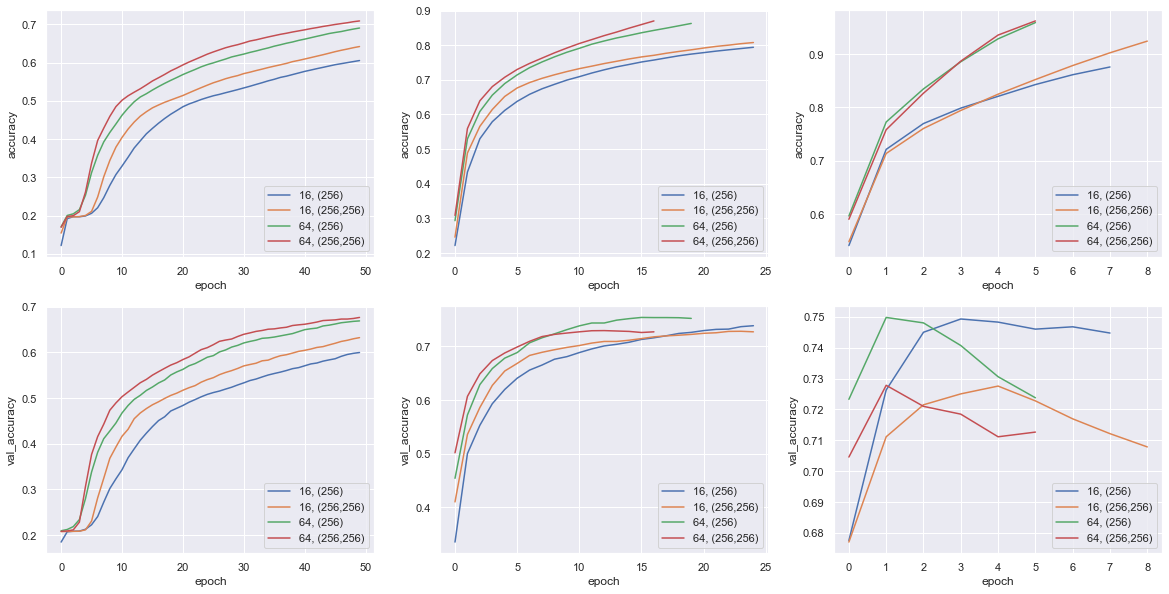

In [667]:
labels = hyperparams_df.apply(lambda x: str(x['embedding_dim'])+', ('+str(x['dense_layers']+')'),axis=1)

fig,axes = plt.subplots(2, 3, figsize=(20,10))
for i in range(len(accuracy.columns)):
    sns.lineplot(ax=axes[0,i//4], x = history['epoch'], y = accuracy.iloc[:,i], legend='brief', label=labels[i])
    sns.lineplot(ax=axes[1,i//4], x = history['epoch'], y = val_accuracy.iloc[:,i], legend='brief', label=labels[i])

#####
<p style="font-weight: 500; color: #556;">Now let's try making a set of binary models using these techniques, and our preferred set of hyperparameters for comparison:</p>

In [668]:
train_data_onehot = model_data_onehot['train_data']
val_data_onehot = model_data_onehot['val_data']

In [671]:
best_model_index = np.argmax(np.max(val_accuracy))
best_hps = list(hyperparams_df.iloc[best_model_index,:])

In [676]:
best_hps

[0.0001, 64, '256']

In [677]:
for i in range(len(cuisine_groups)):
    if i==0:
        model_onehot = []
        history_onehot = []
        preds_onehot = []
    model_onehot.append(
        embedding_model(input_length=token_length, categories=1, lr=best_hps[0], embedding_dim=best_hps[1], dense_layers=best_hps[2], metrics=['accuracy'])
    )
    print('Training Model',i+1,':',cuisine_groups[i])
    history_onehot.append(model_onehot[-1].fit(
        train_data_onehot[i],
        epochs = 50,
        validation_data = val_data_onehot[i],
        verbose = 0,
        callbacks = [early_stopping]
    ).history)
    save_model(model_onehot[-1],'models/model_dense_onehot_'+cuisine_groups[i]+'.h5')
    preds_onehot.append(model_onehot[-1].predict(val_data_onehot[0], verbose=0))
history_onehot = pd.concat([pd.DataFrame(h) for h in history_onehot],axis=1).reset_index()
history_onehot.columns = ['epoch']+list(history_onehot.columns)[1:]
history_onehot.to_csv('model_data/history_dense_onehot.csv',index=False)

Training Model 1 : brazilian
Training Model 2 : british
Training Model 3 : cajun_creole
Training Model 4 : chinese
Training Model 5 : filipino
Training Model 6 : french
Training Model 7 : greek
Training Model 8 : indian
Training Model 9 : irish
Training Model 10 : italian
Training Model 11 : jamaican
Training Model 12 : japanese
Training Model 13 : korean
Training Model 14 : mexican
Training Model 15 : moroccan
Training Model 16 : russian
Training Model 17 : southern_us
Training Model 18 : spanish
Training Model 19 : thai
Training Model 20 : vietnamese


In [679]:
model_onehot[-1].predict(val_data_onehot[0])

124/124 [==============================] - 0s 2ms/step


array([[9.7955042e-04],
       [2.4527108e-06],
       [2.9303583e-06],
       ...,
       [5.1531042e-05],
       [3.4186949e-03],
       [5.1773927e-04]], dtype=float32)

In [683]:
preds_onehot = np.argmax(np.asarray(preds_onehot).squeeze(),axis=0)
real_onehot = np.argmax(model_data_onehot['val_labels'],1)
preds_real_onehot = pd.DataFrame(np.array([preds_onehot,real_onehot]).T,columns=['pred','real'])

In [689]:
accuracy_onehot = pd.concat([history_onehot.iloc[:,i:i+1] for i in range(2,len(history_onehot.columns),4)],axis=1)
val_accuracy_onehot = pd.concat([history_onehot.iloc[:,i:i+1] for i in range(4,len(history_onehot.columns),4)],axis=1)

In [685]:
print('Accuracy is:',np.mean(real_onehot==preds_onehot))

Accuracy is: 0.7710386656557998


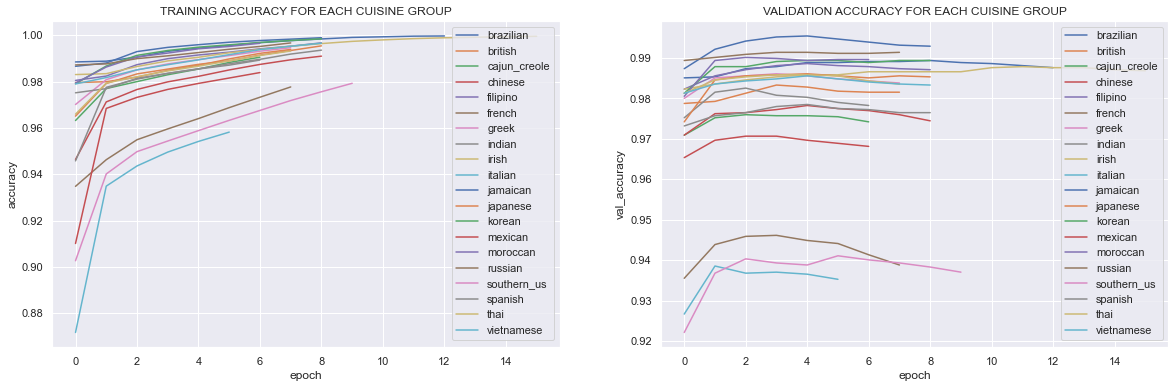

In [701]:
fig,axes = plt.subplots(1, 2, figsize=(20,6))
print('')
for i in range(len(accuracy_onehot.columns)):
    sns.lineplot(ax=axes[0], x = history_onehot['epoch'], y = accuracy_onehot.iloc[:,i], legend='brief',
                 label=cuisine_groups[i]).set_title('TRAINING ACCURACY FOR EACH CUISINE GROUP')
    sns.lineplot(ax=axes[1], x = history_onehot['epoch'], y = val_accuracy_onehot.iloc[:,i], legend='brief',
                 label=cuisine_groups[i]).set_title('VALIDATION ACCURACY FOR EACH CUISINE GROUP')

#####
<p style="font-weight: 500; color: #556;">We've achieved <strong>77.10%</strong> - outstanding! It comes as no surprise that we've seen a significant jump when attacking the data from a binary perspective.<br>Let's take a look at our <strong>confusion matrices</strong> for both our multiclass and one-hot cases, to see where we net out with ech of the cuisines.  Some are visibly harder to predict than others:</p>

In [734]:
make_confusion_matrix(preds_real, groups=cuisine_groups)

,brazilian,british,cajun_creole,chinese,filipino,french,greek,indian,irish,italian,jamaican,japanese,korean,mexican,moroccan,russian,southern_us,spanish,thai,vietnamese
0,70.968,0.000,0.741,0.000,6.557,1.567,1.176,0.643,0.000,0.785,2.273,0.840,0.000,0.932,0.000,0.000,0.579,4.819,1.333,0.000
1,0.000,52.500,0.000,0.000,0.000,4.075,1.176,0.965,15.094,0.785,2.273,0.000,0.000,0.155,0.000,7.143,5.405,0.000,0.000,0.000
2,3.226,0.000,72.593,0.000,0.000,2.821,0.000,0.000,1.887,0.561,0.000,0.000,0.000,0.776,0.000,7.143,6.371,1.205,0.000,0.000
3,0.000,0.000,0.000,76.000,4.918,0.313,0.000,0.000,0.000,0.897,0.000,1.681,6.944,0.621,0.000,0.000,0.386,1.205,4.000,4.444
4,9.677,2.500,0.000,3.273,52.459,0.313,0.000,0.322,0.000,0.448,2.273,0.840,0.000,1.087,0.000,0.000,1.158,1.205,0.667,4.444
5,0.000,2.500,3.704,0.000,0.000,57.053,2.353,0.000,1.887,6.839,2.273,0.840,0.000,0.155,1.515,0.000,5.212,6.024,0.000,0.000
6,3.226,0.000,0.000,0.000,0.000,0.627,72.941,0.000,0.000,2.578,2.273,0.000,0.000,0.155,1.515,0.000,0.965,2.410,0.000,0.000
7,0.000,0.000,0.000,0.364,3.279,0.313,2.353,87.138,0.000,0.336,0.000,4.202,0.000,0.466,7.576,0.000,0.965,1.205,2.667,0.000
8,0.000,12.500,0.000,0.000,0.000,3.448,0.000,0.000,62.264,0.448,0.000,0.000,0.000,0.311,0.000,14.286,2.317,1.205,0.000,0.000
9,0.000,2.500,0.000,1.455,1.639,15.047,8.235,0.000,1.887,80.269,2.273,0.840,0.000,1.863,3.030,7.143,3.861,8.434,0.000,0.000


In [735]:
make_confusion_matrix(preds_real_onehot, groups=cuisine_groups)

,brazilian,british,cajun_creole,chinese,filipino,french,greek,indian,irish,italian,jamaican,japanese,korean,mexican,moroccan,russian,southern_us,spanish,thai,vietnamese
0,71.429,0.000,0.680,0.000,0.000,1.714,1.087,0.637,0.000,0.666,4.255,0.000,0.000,1.069,0.000,0.000,0.633,5.263,1.274,2.128
1,0.000,57.143,0.680,0.000,0.000,3.714,1.087,1.274,2.381,0.999,2.128,0.000,0.000,0.305,0.000,9.524,4.641,0.000,0.000,0.000
2,2.857,0.000,72.109,0.000,0.000,1.714,0.000,0.000,2.381,0.999,0.000,0.000,0.000,0.916,0.000,9.524,4.641,1.754,0.000,0.000
3,5.714,0.000,0.680,81.102,6.667,0.571,0.000,0.000,0.000,0.666,0.000,1.786,7.143,0.611,0.000,0.000,0.633,0.000,4.459,2.128
4,2.857,0.000,0.000,3.150,60.000,0.857,0.000,0.318,0.000,0.555,0.000,1.786,2.857,0.916,0.000,4.762,0.844,0.000,0.637,0.000
5,0.000,6.122,4.082,0.000,0.000,57.143,2.174,0.318,0.000,5.882,0.000,0.000,0.000,0.458,1.370,0.000,3.587,3.509,0.000,0.000
6,0.000,2.041,0.000,0.000,0.000,1.714,70.652,0.000,0.000,2.220,0.000,0.000,0.000,0.153,1.370,0.000,0.844,0.000,0.000,0.000
7,0.000,2.041,0.000,0.000,3.333,0.286,2.174,86.943,0.000,0.333,0.000,0.893,1.429,0.916,6.849,0.000,0.844,0.000,2.548,0.000
8,0.000,8.163,0.680,0.000,1.667,2.571,1.087,0.000,78.571,0.666,0.000,0.000,0.000,0.305,0.000,0.000,2.532,1.754,0.000,0.000
9,0.000,2.041,0.000,0.000,1.667,14.000,9.783,0.318,2.381,80.133,2.128,1.786,0.000,1.832,1.370,4.762,3.797,5.263,0.000,0.000


In [768]:
confusion = make_confusion_matrix(preds_real, groups=cuisine_groups, raw=True)
confusion_onehot = make_confusion_matrix(preds_real_onehot, groups=cuisine_groups, raw=True)
diag, diag_onehot = [],[]
for i in range(len(cuisine_groups)):
    diag.append(confusion.iloc[i,i])
    diag_onehot.append(confusion_onehot.iloc[i,i])
diag_diff = confusion.T.iloc[:,:1]
diag_diff[0] = np.round(np.array(diag_onehot)-np.array(diag),3)
diag_diff.columns = ['diff']
diag_diff = diag_diff.T

In [771]:
diag_diff

,brazilian,british,cajun_creole,chinese,filipino,french,greek,indian,irish,italian,jamaican,japanese,korean,mexican,moroccan,russian,southern_us,spanish,thai,vietnamese
diff,0.461,4.643,-0.484,5.102,7.541,0.09,-2.289,-0.196,16.307,-0.136,8.124,5.882,-0.595,-0.871,1.453,-2.381,5.016,15.853,-0.293,9.929


In [777]:
print('Mean Confusion Gain:',np.round(np.sum(np.array(diag_onehot)-np.array(diag)),4)/len(cuisine_groups))

Mean Confusion Gain: 3.65785


#####
<p style="font-weight: 500; color: #556;">The one-hot results are better for 13 out of 20 cuisine groups, but crucially, they are <strong>significantly</strong> better for some over others. We propose a metric above, the "Mean Confusion Gain" which seeks to quantify this, and have an average of 3.65% per group.  Some of our hardest groups from the multicalss case (irish, Spanish, Vietnamese) see near or over double-dsight improvements when presented with a one-vs-rest model</p>

####
####
#### **CASCADING MULTICLASS PREDICTIONS**

<p style="font-weight: 500; color: #556;">Using intuition from these results, we also have the option of building a set of cascading models. This involves letting the least "confused" group take all of the values that it wants from the test set, and then proceding with a reduced train set that does not include this class, before only two remain - the method is shown below:</p>

In [792]:
from sklearn.metrics import f1_score

for i in range(len(cuisine_groups),1,-1):
    if i==len(cuisine_groups):
        models_cascade = []
        history_cascade = []
        preds_cascade = []
        cascade_results = []
        cuisine_cascade = cuisine_groups
    model_data_cascade = text_prepare(train_df[train_df['cuisine'].isin(cuisine_cascade)][['recipe_clean','cuisine']],
                                      num_words = VOCAB_SIZE, max_len = 30, encode = 'ordinal')
    
    train_data_cascade = model_data_cascade['train_data'][0].batch(64)
    val_data_cascade = model_data_cascade['val_data'][0].batch(64)
    num_cats = 1 if len(cuisine_cascade) < 3 else len(cuisine_cascade)
    models_cascade.append(embedding_model(input_length=30, categories=num_cats, lr=1e-4, embedding_dim=64, dense_layers='256'))
    
    print('Training Model:',i,'classes',end='')
    epochs = 25
    
    history_cascade.append(models_cascade[-1].fit(
        train_data_cascade,
        epochs = epochs,
        validation_data = val_data_cascade,
        verbose = 0,
        callbacks = [early_stopping]
    ).history)

    save_model(models_cascade[-1],'models/model_dense_cascade_'+str(i+1-len(cuisine_groups))+'.h5')

    preds = models_cascade[-1].predict(val_data_cascade, verbose=0)
    if len(preds[0])>1:
        preds = np.argmax(preds,axis=1)
    else:
        preds = np.round(preds.squeeze())
    preds_cascade.append()
    preds_real_cascade = pd.concat([pd.DataFrame(preds_cascade[-1],columns=['pred']),pd.DataFrame(model_data_cascade['val_labels'],columns=['real'])],axis=1)
    diag = []
        
    for i in range(len(cuisine_cascade)):
        s = np.array(preds_real_cascade).T
        s = np.array([np.where(s[0]==i,1,0),np.where(s[1]==i,1,0)])
        diag.append(f1_score(s[1],s[0])) # we use the F1 score as a measure of safety
        
    least_confusion = np.max(diag)
    least_confusion_index = np.argmax(diag)
    cascade_results.append((cuisine_cascade[least_confusion_index],
                            least_confusion,
                            len(np.where(model_data_cascade['val_labels']==least_confusion_index)[0])))
    print(': results = ',cascade_results)
    cuisine_cascade = np.concatenate([cuisine_cascade[:least_confusion_index],cuisine_cascade[least_confusion_index+1:]])

Training Model: 20 classes: results =  [('13 mexican', 0.8977002379064235, 616)]
Training Model: 19 classes: results =  [('7 indian', 0.8841761827079935, 302)]
Training Model: 18 classes: results =  [('9 italian', 0.8484848484848485, 817)]
Training Model: 17 classes: results =  [('14 moroccan', 0.8607594936708861, 86)]
Training Model: 16 classes: results =  [('3 chinese', 0.821969696969697, 246)]
Training Model: 15 classes: results =  [('12 korean', 0.8242424242424243, 79)]
Training Model: 14 classes: results =  [('11 japanese', 0.8484848484848485, 136)]
Training Model: 13 classes: results =  [('18 thai', 0.832258064516129, 153)]
Training Model: 12 classes: results =  [('10 jamaican', 0.8125, 50)]
Training Model: 11 classes: results =  [('19 vietnamese', 0.8085106382978724, 74)]
Training Model: 10 classes: results =  [('6 greek', 0.8020833333333334, 96)]
Training Model: 9 classes: results =  [('16 southern_us', 0.7742663656884875, 411)]
Training Model: 8 classes: results =  [('2 cajun_

In [795]:
preds_all = []
num_matches_total = 0
order = ['mexican','indian','italian','moroccan','chinese','korean','japanese','thai','jamaican',
         'vietnamese','greek','southern_us','cajun_creole','french','spanish','filipino','brazilian','irish','british']
cuisine_groups = list(cuisine_groups)
cuisine_cascade = cuisine_groups
for i in range(len(order)):
    data = text_prepare(train_df[['recipe_clean','cuisine']],
                        train_df[train_df['cuisine'].isin(cuisine_cascade)][['recipe_clean','cuisine']],
                        num_words = VOCAB_SIZE, max_len = 30, encode = 'ordinal')
    val_data_cascade = data['val_data'][0].batch(64)
    val_labels_cascade = data['val_labels']
    decoding = data['label_decoding']
    p = load_model('../models/model_dense_cascade_'+str(21-i)+'.h5').predict(val_data_cascade)
    p = np.argmax(p,axis=1) if i<18 else np.round(p.squeeze()).astype(int)
    cuisine_indices = [cuisine_groups.index(c) for c in cuisine_cascade]
    p_pred = np.array([cuisine_indices[q] for q in p])
    p_real = val_labels_cascade
    num_matches = p_pred[np.where(p_pred==p_real)]
    num_matches = len(num_matches[np.where(num_matches==cuisine_groups.index(order[i]))])
    num_matches_total += num_matches
    print(len(p_pred),num_matches)
    preds_all.append([p_pred,p_real])
    cuisine_cascade = cuisine_cascade[:cuisine_cascade.index(order[i])]+cuisine_cascade[1+cuisine_cascade.index(order[i]):]
    
    if i==len(order)-1:
        final_indices.extend(np.arange(len(preds_all[-1][0]),dtype='int'))
        final_preds.extend(preds_all[-1][0])
    else:
        z = np.where(preds_all[i][0]==cuisine_groups.index(order[i]))[0]
        final_indices.extend(z)
        final_preds.extend(np.ones(len(z),dtype='int')*cuisine_groups.index(order[i]))

preds_df = pd.DataFrame([final_indices,final_preds]).T.reset_index().sort_values(by=[0,'index']).drop_duplicates(subset=[0],keep='first').reset_index(drop=True)
final_aggregated_preds = np.array(preds_df[1])
final_aggregated_real = preds_all[0][1]
accuracy_final_cascade = sum(final_aggregated_preds==final_aggregated_real)/len(final_aggregated_preds)
print('Accuracy is:',accuracy_final_cascade)

62/62 [==============================] - 0s 2ms/step
3957 566
62/62 [==============================] - 0s 2ms/step
3957 272
62/62 [==============================] - 0s 2ms/step
3957 719
62/62 [==============================] - 0s 2ms/step
3957 68
62/62 [==============================] - 0s 3ms/step
3957 214
62/62 [==============================] - 0s 2ms/step
3957 68
62/62 [==============================] - 0s 2ms/step
3957 113
62/62 [==============================] - 0s 2ms/step
3957 129
62/62 [==============================] - 0s 2ms/step
3957 39
62/62 [==============================] - 0s 3ms/step
3957 57
62/62 [==============================] - 0s 2ms/step
3957 79
62/62 [==============================] - 0s 3ms/step
3957 354
62/62 [==============================] - 0s 3ms/step
3957 135
62/62 [==============================] - 0s 3ms/step
3957 263
62/62 [==============================] - 0s 3ms/step
3957 93
62/62 [==============================] - 0s 3ms/step
3957 56
62/62 [========

#####
<p style="font-weight: 500; color: #556;">We've achieved <strong>76.14%</strong> - A good result, but not our best - not yet!  We may get more improvement using a cascading binary system, though this takes a long time to train with the models requird.  It's something open for the future.</p>
<p style="font-weight: 500; color: #556;">For now, we'll look at some other techniques....</p>

####
####
#### **CLASSIFICATION USING RECURRANT NEURAL NETWORKS**


<p style="font-weight: 500; color: #556;">There are potential gains to be made using RNN archictectures; we will not know for sure unless we try!  Here, we may find that the ingredients as served up in a given order offer clues to the recipes origin, rather than just looking at the ingredients themselves in isolation.</p>
<p style="font-weight: 500; color: #556;">Some additional helper functions have been created for this purpose, to address the issue of models being heavy and having the potential to cause memory issues midway.  Each model epoch is stored in a model history function<br></p>

#####
#### **Multiclass Classification**

In [78]:
model_lstm_1 = lstm_model(model_data, loss='sparse_categorical_crossentropy', optimizer = 'adam', rnn_depth = 128, embedding_dim = 64,
                           layer_norm = True, categories = 20, activation = 'softmax', metrics=['accuracy'])

In [80]:
process_model(model_data, model_lstm_1, label = 'cuisine', model_name = 'model_lstm', lr = (1e-3, 1e-3), epochs = 20, batch_size = 512, epoch_subset = 1)

Epoch 1/20
70/70 [==============================] - 10s 89ms/step - loss: 1.7455 - accuracy: 0.4915 - val_loss: 1.0874 - val_accuracy: 0.6748 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 5s 67ms/step - loss: 0.9351 - accuracy: 0.7168 - val_loss: 0.8938 - val_accuracy: 0.7281 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 5s 67ms/step - loss: 0.7614 - accuracy: 0.7666 - val_loss: 0.8249 - val_accuracy: 0.7508 - lr: 0.0010
Epoch 4/20
70/70 [==============================] - 5s 67ms/step - loss: 0.6750 - accuracy: 0.7943 - val_loss: 0.8057 - val_accuracy: 0.7607 - lr: 0.0010
Epoch 5/20
70/70 [==============================] - 5s 67ms/step - loss: 0.6192 - accuracy: 0.8115 - val_loss: 0.8037 - val_accuracy: 0.7647 - lr: 0.0010
Epoch 6/20
70/70 [==============================] - 5s 67ms/step - loss: 0.5865 - accuracy: 0.8178 - val_loss: 0.7934 - val_accuracy: 0.7678 - lr: 0.0010
Epoch 7/20
70/70 [==============================] - 5s 69ms/step - loss: 0.

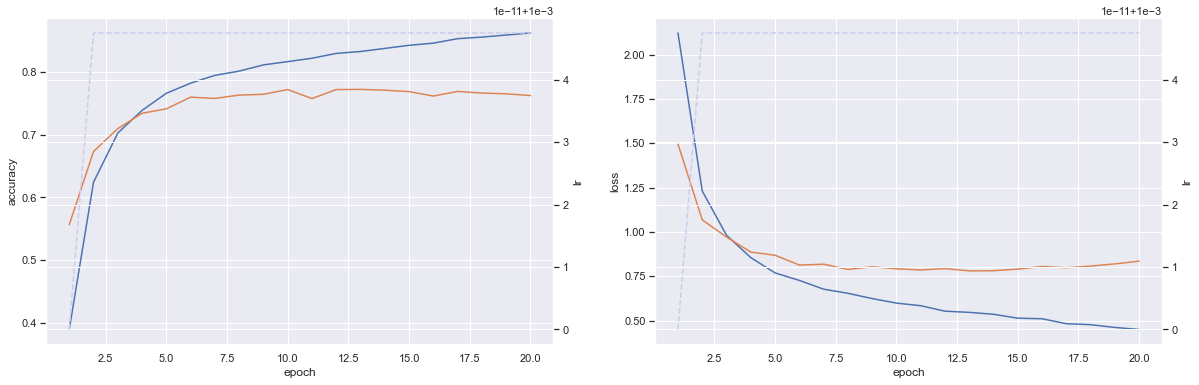

In [165]:
plot_history(model_history(),'model_lstm$',val='overlap')

In [100]:
model_lstm_2 = lstm_model(model_data, loss = 'sparse_categorical_crossentropy', optimizer = 'adam', rnn_depth = 512, embedding_dim = 64,
                           layer_norm = False, categories = 20, activation = 'softmax', metrics=['accuracy'])

In [99]:
process_model(model_data, model_lstm_2, label = 'cuisine', model_name = 'model_lstm_2', lr = (5e-5,1e-3),
              epochs = 100, batch_size = 256, epoch_subset = 1, split_epochs=True)

no model found - initializing
140/140 [==============================] - 22s 156ms/step - loss: 0.3499 - accuracy: 0.8853 - val_loss: 1.0956 - val_accuracy: 0.7307 - lr: 0.0010


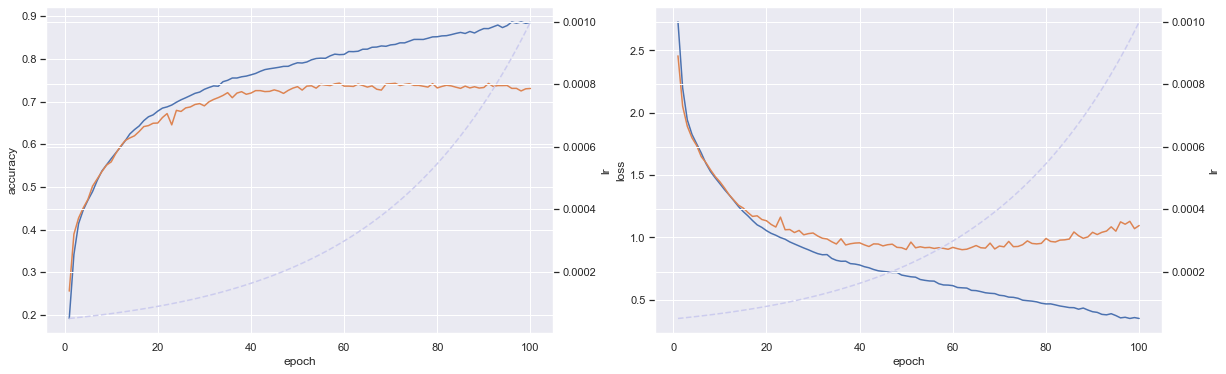

In [10]:
plot_history(model_history(),'model_lstm_2$',val='overlap')

In [ ]:
model_lstm_3 = lstm_model(model_data, loss = 'sparse_categorical_crossentropy', optimizer = 'adam', rnn_depth = 512, embedding_dim = 64,
                           layer_norm = True, categories = 20, activation = 'softmax', metrics=['accuracy'])

In [162]:
process_model(model_data, model_lstm_3, label = 'cuisine', model_name = 'model_lstm_3', lr = (5e-5,1e-3),
              epochs = 100, batch_size = 256, epoch_subset = 1, split_epochs=True)

no model found - initializing
140/140 [==============================] - 22s 159ms/step - loss: 0.1237 - accuracy: 0.9587 - val_loss: 1.7583 - val_accuracy: 0.7362 - lr: 0.0010


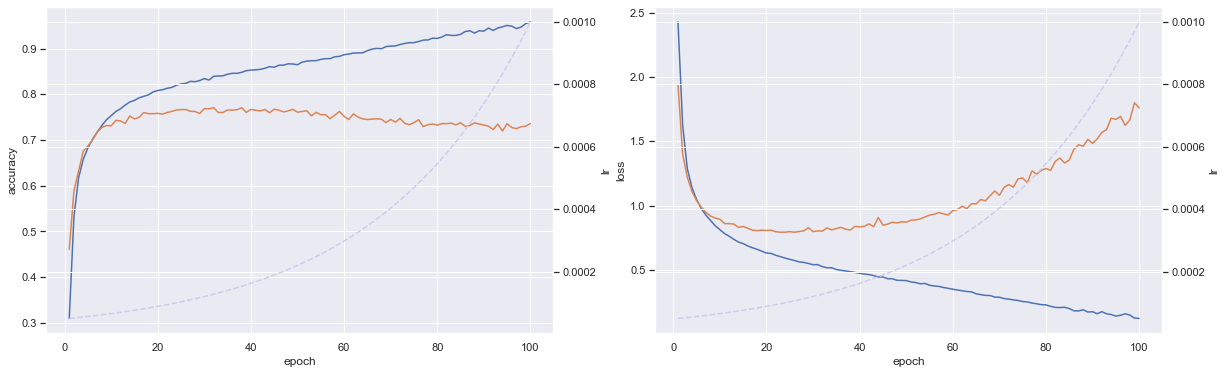

In [11]:
plot_history(model_history(),'model_lstm_3$',val='overlap')

In [118]:
model_lstm_4 = lstm_model(model_data, loss = 'sparse_categorical_crossentropy', optimizer = 'adam', rnn_depth = 512, embedding_dim = 64,
                           layer_norm = True, categories = 20, activation = 'softmax', metrics=['accuracy'])

In [163]:
process_model(model_data, label = 'cuisine', model_name = 'model_lstm_4', lr = (5e-5,1e-3), epochs = 20,
              batch_size = 256, epoch_subset = 1, split_epochs=True)

no model found - initializing
140/140 [==============================] - 22s 158ms/step - loss: 0.5669 - accuracy: 0.8236 - val_loss: 0.8260 - val_accuracy: 0.7574 - lr: 0.0010


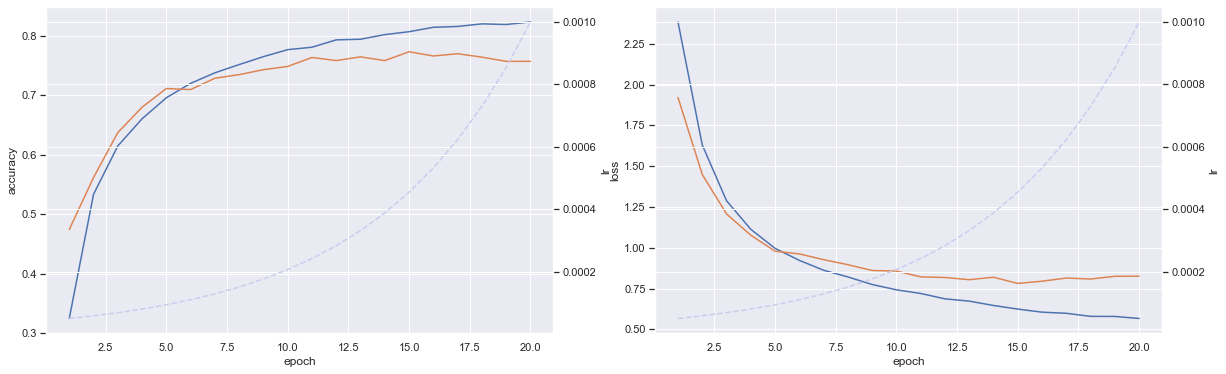

In [12]:
plot_history(model_history(),'model_lstm_4$',val='overlap')

In [59]:
model_lstm_5 = lstm_model(model_data, loss='sparse_categorical_crossentropy', optimizer='adam', rnn_depth=512, embedding_dim=64,
                          layer_norm = True, categories = 20, activation = 'softmax', metrics=['accuracy'])

In [61]:
process_model(model_data, model_lstm_5, label = 'cuisine', model_name = 'model_lstm_5', lr = (5e-5,1e-3),
              epochs = 20, batch_size = 256, epoch_subset = 1, class_weight = True, split_epochs=True)

140/140 [==============================] - 23s 148ms/step - loss: 0.6393 - accuracy: 0.1187 - val_loss: 2.5859 - val_accuracy: 0.2004 - lr: 5.0000e-05


140/140 [==============================] - 20s 140ms/step - loss: 0.4905 - accuracy: 0.3387 - val_loss: 1.8118 - val_accuracy: 0.4299 - lr: 5.8539e-05


140/140 [==============================] - 20s 140ms/step - loss: 0.3728 - accuracy: 0.5036 - val_loss: 1.4294 - val_accuracy: 0.5504 - lr: 6.8536e-05


140/140 [==============================] - 20s 143ms/step - loss: 0.3157 - accuracy: 0.5864 - val_loss: 1.3676 - val_accuracy: 0.5684 - lr: 8.0241e-05


140/140 [==============================] - 20s 143ms/step - loss: 0.2806 - accuracy: 0.6332 - val_loss: 1.2357 - val_accuracy: 0.6113 - lr: 9.3944e-05


140/140 [==============================] - 20s 144ms/step - loss: 0.2579 - accuracy: 0.6616 - val_loss: 1.1271 - val_accuracy: 0.6538 - lr: 1.0999e-04


140/140 [==============================] - 20s 143ms/step - loss: 0.2371 - accuracy: 0.6851 - val_loss: 1.1189 - val_accuracy: 0.6566 - lr: 1.2877e-04


140/140 [==============================] - 21s 148ms/step - loss: 0.2209 - accuracy: 0.6983 - val_loss: 1.0240 - val_accuracy: 0.6856 - lr: 1.5076e-04


140/140 [==============================] - 21s 150ms/step - loss: 0.2097 - accuracy: 0.7167 - val_loss: 1.1008 - val_accuracy: 0.6603 - lr: 1.7651e-04


140/140 [==============================] - 20s 142ms/step - loss: 0.1982 - accuracy: 0.7232 - val_loss: 1.1434 - val_accuracy: 0.6576 - lr: 2.0666e-04


140/140 [==============================] - 20s 139ms/step - loss: 0.1894 - accuracy: 0.7328 - val_loss: 0.9942 - val_accuracy: 0.7028 - lr: 2.4195e-04


140/140 [==============================] - 20s 140ms/step - loss: 0.1818 - accuracy: 0.7418 - val_loss: 1.0903 - val_accuracy: 0.6667 - lr: 2.8327e-04


140/140 [==============================] - 20s 143ms/step - loss: 0.1775 - accuracy: 0.7437 - val_loss: 0.9840 - val_accuracy: 0.7142 - lr: 3.3164e-04


140/140 [==============================] - 20s 142ms/step - loss: 0.1673 - accuracy: 0.7552 - val_loss: 0.9173 - val_accuracy: 0.7296 - lr: 3.8828e-04


140/140 [==============================] - 20s 141ms/step - loss: 0.1643 - accuracy: 0.7570 - val_loss: 1.0322 - val_accuracy: 0.6965 - lr: 4.5459e-04


140/140 [==============================] - 20s 141ms/step - loss: 0.1586 - accuracy: 0.7614 - val_loss: 0.9652 - val_accuracy: 0.7159 - lr: 5.3223e-04


140/140 [==============================] - 20s 144ms/step - loss: 0.1598 - accuracy: 0.7562 - val_loss: 0.9952 - val_accuracy: 0.7010 - lr: 6.2312e-04


140/140 [==============================] - 20s 142ms/step - loss: 0.1510 - accuracy: 0.7692 - val_loss: 0.9465 - val_accuracy: 0.7187 - lr: 7.2954e-04


140/140 [==============================] - 20s 140ms/step - loss: 0.1519 - accuracy: 0.7660 - val_loss: 1.0725 - val_accuracy: 0.6940 - lr: 8.5413e-04


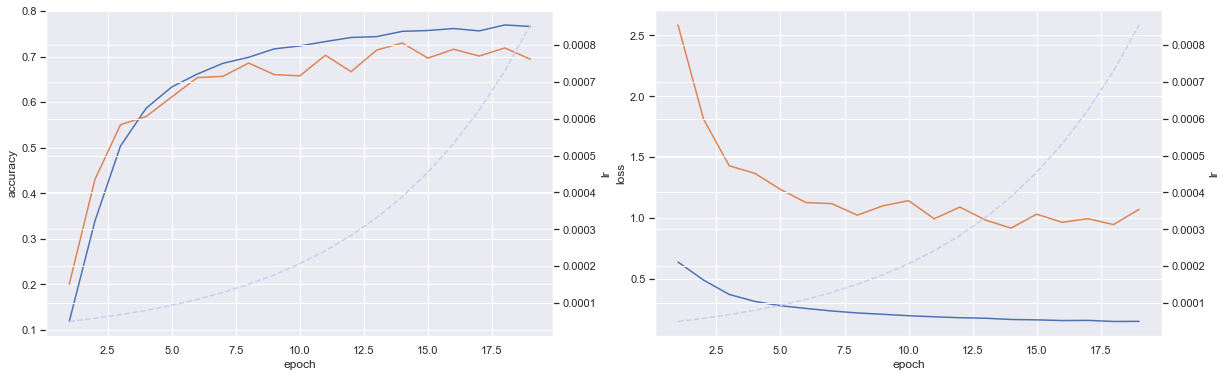

In [62]:
plot_history(model_history(),'model_lstm_5$',val='overlap')

In [63]:
model_lstm_6 = lstm_model(model_data, loss = 'sparse_categorical_crossentropy', optimizer = 'adam', rnn_depth = 512, embedding_dim = 64,
                          layer_norm = True, categories = 20, activation = 'softmax', metrics=['accuracy'])

In [64]:
process_model(model_data, model_lstm_6, label = 'cuisine', model_name = 'model_lstm_6', lr = (5e-5,1e-3),
              epochs = 20, batch_size = 16, epoch_subset = 1, class_weight = True, split_epochs=True)

2227/2227 [==============================] - 86s 38ms/step - loss: 0.4620 - accuracy: 0.3746 - val_loss: 1.2966 - val_accuracy: 0.6085 - lr: 5.0000e-05


2227/2227 [==============================] - 83s 37ms/step - loss: 0.3024 - accuracy: 0.6094 - val_loss: 1.3286 - val_accuracy: 0.5959 - lr: 5.8539e-05


2227/2227 [==============================] - 83s 37ms/step - loss: 0.2573 - accuracy: 0.6646 - val_loss: 1.0518 - val_accuracy: 0.6773 - lr: 6.8536e-05


2227/2227 [==============================] - 86s 38ms/step - loss: 0.2304 - accuracy: 0.6932 - val_loss: 0.9905 - val_accuracy: 0.7033 - lr: 8.0241e-05


2227/2227 [==============================] - 83s 37ms/step - loss: 0.2133 - accuracy: 0.7133 - val_loss: 1.0582 - val_accuracy: 0.6821 - lr: 9.3944e-05


2227/2227 [==============================] - 82s 37ms/step - loss: 0.1987 - accuracy: 0.7263 - val_loss: 0.9660 - val_accuracy: 0.7144 - lr: 1.0999e-04


2227/2227 [==============================] - 139s 62ms/step - loss: 0.1889 - accuracy: 0.7341 - val_loss: 0.9993 - val_accuracy: 0.6972 - lr: 1.2877e-04


2227/2227 [==============================] - 86s 38ms/step - loss: 0.1809 - accuracy: 0.7411 - val_loss: 1.1016 - val_accuracy: 0.6674 - lr: 1.5076e-04


2227/2227 [==============================] - 85s 38ms/step - loss: 0.1733 - accuracy: 0.7478 - val_loss: 1.0921 - val_accuracy: 0.6839 - lr: 1.7651e-04


2227/2227 [==============================] - 84s 38ms/step - loss: 0.1692 - accuracy: 0.7527 - val_loss: 1.0767 - val_accuracy: 0.6780 - lr: 2.0666e-04


2227/2227 [==============================] - 85s 38ms/step - loss: 0.1650 - accuracy: 0.7575 - val_loss: 0.9734 - val_accuracy: 0.7175 - lr: 2.4195e-04


2227/2227 [==============================] - 87s 39ms/step - loss: 0.1593 - accuracy: 0.7596 - val_loss: 1.1480 - val_accuracy: 0.6533 - lr: 2.8327e-04


2227/2227 [==============================] - 88s 39ms/step - loss: 0.1568 - accuracy: 0.7625 - val_loss: 0.9848 - val_accuracy: 0.7162 - lr: 3.3164e-04


2227/2227 [==============================] - 87s 39ms/step - loss: 0.1547 - accuracy: 0.7641 - val_loss: 1.0630 - val_accuracy: 0.6940 - lr: 3.8828e-04


2227/2227 [==============================] - 85s 38ms/step - loss: 0.1504 - accuracy: 0.7689 - val_loss: 1.1781 - val_accuracy: 0.6783 - lr: 4.5459e-04


2227/2227 [==============================] - 85s 38ms/step - loss: 0.1495 - accuracy: 0.7677 - val_loss: 1.0789 - val_accuracy: 0.6894 - lr: 5.3223e-04


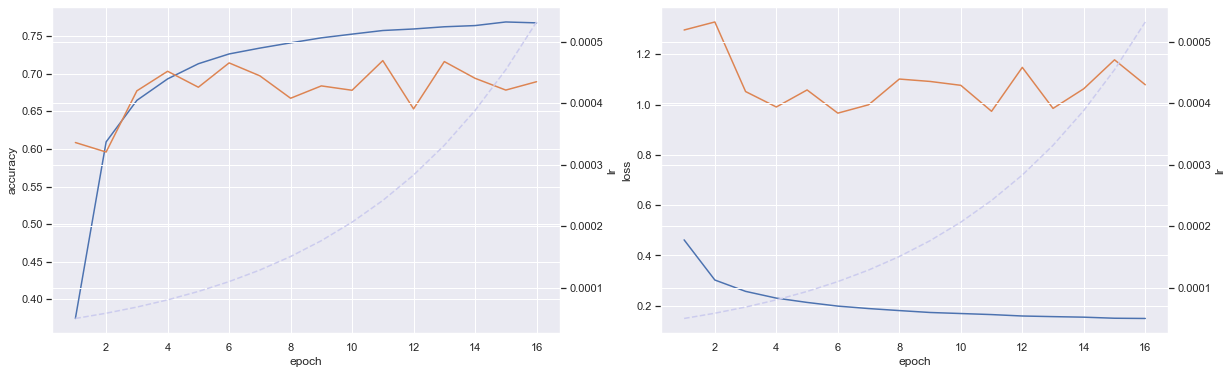

In [65]:
plot_history(model_history(),'model_lstm_6$',val='overlap')

#####
#### **One vs Rest Binary Classification**

Lorem ipsum dolor sit amet

In [57]:
cuisine_groups = list(model_data_onehot['label_encoding'].keys())

In [167]:
model_onehot = lstm_model(model_data_onehot, loss = 'binary_crossentropy', optimizer = 'adam', rnn_depth = 128, embedding_dim = 32,
                          layer_norm = True, categories = 1, activation = 'sigmoid', metrics=[my_auc,'accuracy'])
for i,c in enumerate(cuisine_groups):
    process_model(model_data_onehot, model_onehot, label_class = i, label = 'cuisine_'+c, model_name = 'model_lstm_onehot_'+c,
                  lr = (5e-5,1e-3), epochs = 50, batch_size = 64, epoch_subset = 1, split_epochs = True) #, model_path = MODEL_PATH_TEST, history_path = HISTORY_PATH_TEST)

no model found - initializing
560/560 [==============================] - 23s 40ms/step - loss: 0.0125 - accuracy: 0.9958 - auc: 0.9953 - val_loss: 0.1099 - val_accuracy: 0.9799 - val_auc: 0.8910 - lr: 0.0010
no model found - initializing
560/560 [==============================] - 23s 41ms/step - loss: 0.0391 - accuracy: 0.9847 - auc: 0.9963 - val_loss: 0.3220 - val_accuracy: 0.9243 - val_auc: 0.9076 - lr: 0.0010
no model found - initializing
560/560 [==============================] - 24s 42ms/step - loss: 0.0099 - accuracy: 0.9964 - auc: 0.9955 - val_loss: 0.0800 - val_accuracy: 0.9862 - val_auc: 0.8153 - lr: 0.0010
no model found - initializing
560/560 [==============================] - 24s 42ms/step - loss: 0.0123 - accuracy: 0.9953 - auc: 0.9989 - val_loss: 0.1388 - val_accuracy: 0.9703 - val_auc: 0.9500 - lr: 0.0010
no model found - initializing
560/560 [==============================] - 24s 44ms/step - loss: 0.0041 - accuracy: 0.9984 - auc: 0.9998 - val_loss: 0.0498 - val_accuracy

Lets take a look at some of our results here:

In [68]:
hist = model_history()
hist = hist[hist['name'].str.contains('model_lstm_onehot_('+('|'.join(cuisine_groups))+')$')].reset_index(drop=True)

In [69]:
hist[['label','epoch','val_loss','val_auc','val_accuracy']].groupby(['label','epoch']).sum().reset_index()

,label,epoch,val_loss,val_auc,val_accuracy
0,cuisine_brazilian,1,0.062921,0.701884,0.987428
1,cuisine_brazilian,2,0.053329,0.817369,0.987428
2,cuisine_brazilian,3,0.039472,0.889631,0.989439
3,cuisine_brazilian,4,0.036084,0.918319,0.991702
4,cuisine_brazilian,5,0.037096,0.924854,0.990194
...,...,...,...,...,...
995,cuisine_vietnamese,46,0.104217,0.879163,0.982650
996,cuisine_vietnamese,47,0.105945,0.894570,0.976364
997,cuisine_vietnamese,48,0.110108,0.885021,0.982399
998,cuisine_vietnamese,49,0.114913,0.862266,0.981645


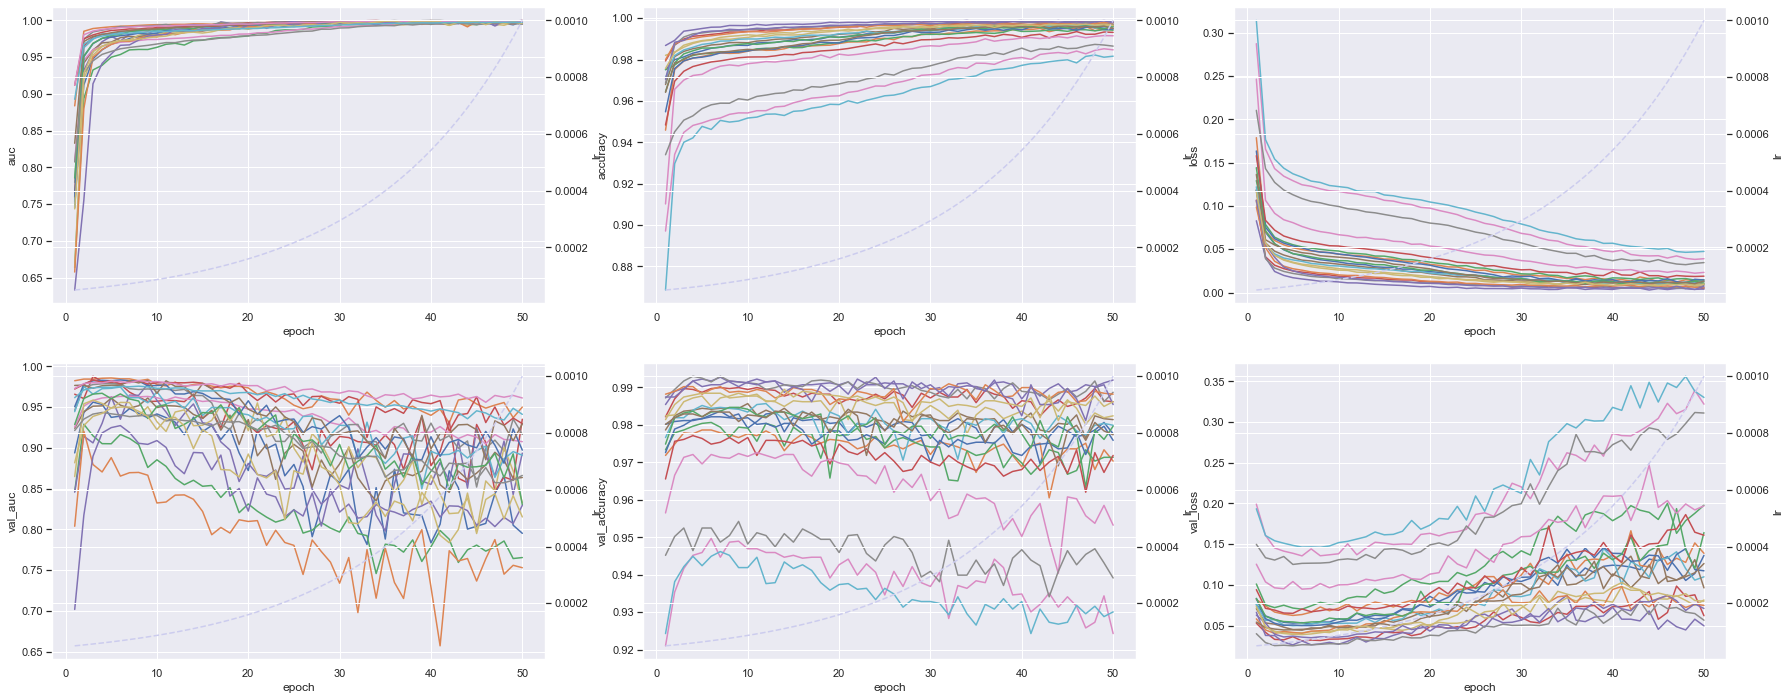

In [166]:
filters = 'model_lstm_onehot_('+('|'.join(cuisine_groups))+')$'
plot_history(model_history(), filters, metrics=['auc','accuracy','loss'], width=3, height=2, tight=False, size=(30,12), val='separate')

# fix these scales!
# show the bootstrapped line only

<br>Let's combine our one-hot predictions to get a holistic accuracy score:

In [302]:
preds_onehot = []
for i,p in enumerate(cuisine_groups):
    m = load_model(MODEL_PATH+'model_lstm_onehot_'+p+'_best.h5')
    preds_onehot.append(m.predict(model_data_onehot['val_data'][i], verbose=0)) #.map(lambda x,y: x[np.newaxis])

In [327]:
preds_onehot_df = pd.DataFrame([[s[0] for s in p] for p in preds_onehot]).transpose()
preds_onehot_df.columns = cuisine_groups
np.round(preds_onehot_df,5)

,brazilian,british,cajun_creole,chinese,filipino,french,greek,indian,irish,italian,jamaican,japanese,korean,mexican,moroccan,russian,southern_us,spanish,thai,vietnamese
0,0.00033,0.00022,0.00011,0.02568,0.00126,0.00007,0.00007,0.00001,0.00009,0.00714,0.02271,0.00452,0.00008,0.00035,0.00017,0.00054,0.00045,0.00436,0.00011,0.00013
1,0.00061,0.00023,0.00069,0.00065,0.00002,0.00040,0.00243,0.00000,0.00005,0.01135,0.00000,0.00004,0.00001,0.93897,0.00005,0.00083,0.00137,0.00165,0.00000,0.00001
2,0.00065,0.00370,0.07713,0.00026,0.00002,0.01770,0.00774,0.00001,0.04211,0.00006,0.00001,0.00056,0.00001,0.03615,0.00010,0.00491,0.00116,0.00258,0.00000,0.00000
3,0.00056,0.00398,0.00031,0.00649,0.00036,0.00204,0.00565,0.40284,0.00085,0.00346,0.00209,0.03505,0.00336,0.29195,0.00952,0.00358,0.01478,0.00100,0.01069,0.00430
4,0.00076,0.01906,0.00592,0.44077,0.00058,0.02477,0.01606,0.01027,0.01929,0.00189,0.01708,0.00167,0.00184,0.02363,0.00389,0.02148,0.01301,0.00521,0.00209,0.00230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3952,0.84328,0.00223,0.00051,0.00148,0.06030,0.00245,0.00177,0.00119,0.00107,0.03792,0.00452,0.00102,0.00044,0.91299,0.00132,0.00241,0.01565,0.00366,0.00070,0.00456
3953,0.00440,0.02988,0.00649,0.12174,0.00216,0.04092,0.00681,0.06625,0.02056,0.07176,0.00524,0.18040,0.00552,0.09528,0.00251,0.02195,0.03962,0.00676,0.04006,0.02654
3954,0.00276,0.00114,0.00008,0.00257,0.00022,0.03926,0.03869,0.00210,0.00045,0.01168,0.00002,0.00013,0.01257,0.00062,0.00111,0.00360,0.00011,0.00377,0.00320,0.00025
3955,0.00006,0.00045,0.00004,0.16377,0.00013,0.00008,0.00009,0.00694,0.00004,0.00113,0.00061,0.00468,0.00005,0.00001,0.00019,0.00069,0.03437,0.00031,0.00033,0.00013


In [350]:
onehot_pred = np.asarray([np.argmax(preds_onehot_df.iloc[i,:]) for i in range(len(preds_onehot_df))])[np.newaxis]
onehot_real = np.argmax(model_data_onehot['val_labels'],axis=1)[np.newaxis]
onehot_pred_real = pd.DataFrame(np.concatenate([onehot_pred,onehot_real],axis=0).T,columns=['pred','real'])
onehot_pred_real['acc'] = np.where(onehot_pred_real['pred']-onehot_pred_real['real']==0,1,0)
print('Accuracy is:',sum(onehot_pred_real['acc'])/len(onehot_pred_real))

Accuracy is: 0.7842594920794569


#####
#### **Fine Tuning (to be continued)**
Let's just look at one specific label and try and improve the performance for this alone by adjusting the learning rate to be slower and adjusting other parameters:

In [247]:
my_cuisines = ['greek']

for c in my_cuisines:
    model_tune_1 = lstm_model(model_data_onehot, loss = 'binary_crossentropy', optimizer = 'adam', rnn_depth = 128, embedding_dim = 32,
                              layer_norm = True, categories = 1, activation = 'sigmoid', metrics=[my_auc,'accuracy'])
    process_model(model_data_onehot, model_tune_1, label_class = 6, label = 'cuisine_'+c, model_name = 'model_lstm_onehot_'+c+'_v2', lr = (1e-6,5e-4),
                  epochs = 100, batch_size = 64, epoch_subset = 1, split_epochs=True)

    model_tune_2 = lstm_model(model_data_onehot, loss = 'binary_crossentropy', optimizer = 'adam', rnn_depth = 512, embedding_dim = 64,
                              layer_norm = True, categories = 1, activation = 'sigmoid', metrics=[my_auc,'accuracy'])
    process_model(model_data_onehot, model_tune_2, label_class = 6, label = 'cuisine_'+c, model_name = 'model_lstm_onehot_'+c+'_v3', lr = (1e-5,1e-5),
                  epochs = 20, batch_size = 128, epoch_subset = 1, split_epochs=True)

    model_tune_3 = lstm_model(model_data_onehot, loss = 'binary_crossentropy', optimizer = 'adam', rnn_depth = 64, embedding_dim = 6,
                              layer_norm = True, categories = 1, activation = 'sigmoid', metrics=[my_auc,'accuracy'])
    process_model(model_data_onehot, model_tune_3, label_class = 6, label = 'cuisine_'+c, model_name = 'model_lstm_onehot_'+c+'_v3', lr = (1e-5,1e-5),
                  epochs = 20, batch_size = 16, epoch_subset = 1, split_epochs=True)

no model found - initializing
560/560 [==============================] - 32s 58ms/step - loss: 0.0111 - accuracy: 0.9958 - auc: 0.9983 - val_loss: 0.1276 - val_accuracy: 0.9796 - val_auc: 0.8978 - lr: 5.0000e-04


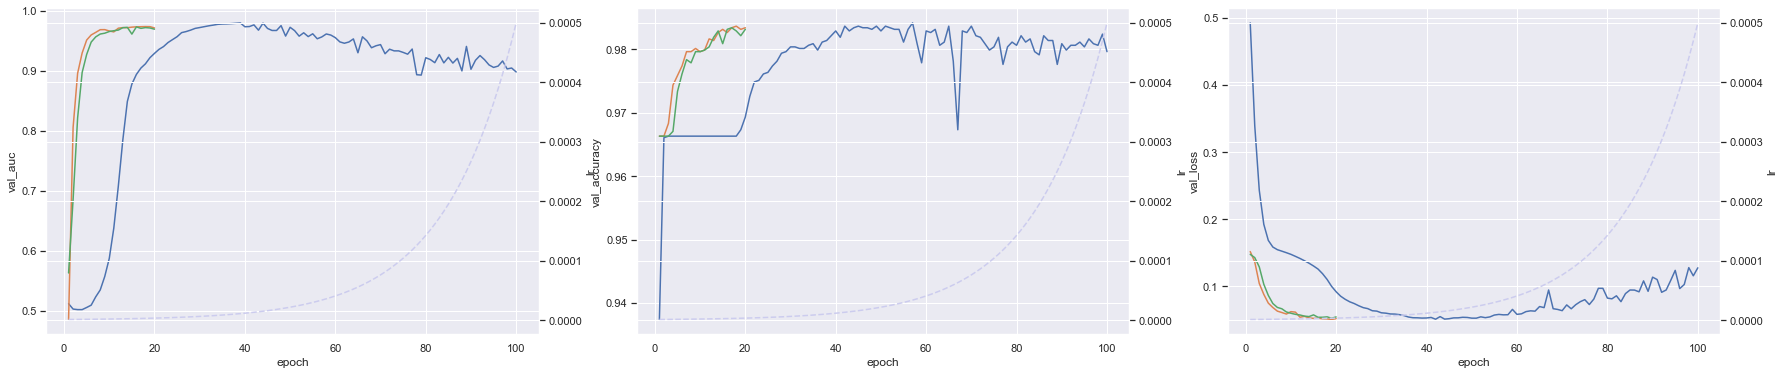

In [194]:
filters = 'model_lstm_onehot_('+('|'.join(cuisine_groups))+')_v.$'
plot_history(model_history(), filters, group='name', metrics=['val_auc','val_accuracy','val_loss'], width=3, height=1, tight=False, size=(30,6))

####

####
#### **USING COMPOUND WORD CANDIDATES - REPETITION AND RANDOMIZATION**

<p style="font-weight: 500; color: #556;">This time we'll need to modify the preparation function</p>

In [209]:
np.random.seed(79)
train_df_shuffled = train_df.iloc[:,:3].sample(frac=1).reset_index(drop=True)
if type(train_df_shuffled['ingredients'][0])==str:
    train_df_shuffled['ingredients'] = train_df_shuffled['ingredients'].apply(lambda x: eval(x))
train_df_shuffled.head()

,id,cuisine,ingredients
0,44421,chinese,"[large egg whites, boneless skinless chicken b..."
1,19718,southern_us,"[matzo meal, paprika, ground white pepper, lar..."
2,9055,chinese,"[soy sauce, garlic, hoisin sauce, honey, chine..."
3,5142,mexican,"[yellow bell pepper, red bell pepper, olive oi..."
4,17592,italian,"[water, salt, olive oil, bread flour, active d..."


In [210]:
copies = 20
removal_rate = 0.4

In [211]:
train_df_shuffled['recipe_concat'] = train_df_shuffled['ingredients'].apply(lambda x: ' '.join([re.sub(' ','_',i) for i in x]))
train_df_shuffled['recipe_clean'] = train_df_shuffled['recipe_concat'].apply(lambda x: text_clean(x))

In [212]:
id2 = np.arange(len(train_df_shuffled))
random.shuffle(id2)
id2 = pd.DataFrame(id2,columns=['id2'])
train_df_shuffled = pd.concat([train_df_shuffled,id2],axis=1)

for i in range(copies):
    train_df_shuffled_expanded = train_df_shuffled.copy() if i==0 else train_df_shuffled_expanded.append(train_df_shuffled.copy())
train_df_shuffled_expanded = train_df_shuffled_expanded.sort_values(by='id2').reset_index(drop=True)

In [213]:
train_df_shuffled_expanded

,id,cuisine,ingredients,recipe_concat,recipe_clean,id2
0,34938,southern_us,"[milk, butter, sausages, flour, salt, baking s...",milk butter sausages flour salt baking_soda re...,milk butter sausages flour salt baking_soda re...,0
1,34938,southern_us,"[milk, butter, sausages, flour, salt, baking s...",milk butter sausages flour salt baking_soda re...,milk butter sausages flour salt baking_soda re...,0
2,34938,southern_us,"[milk, butter, sausages, flour, salt, baking s...",milk butter sausages flour salt baking_soda re...,milk butter sausages flour salt baking_soda re...,0
3,34938,southern_us,"[milk, butter, sausages, flour, salt, baking s...",milk butter sausages flour salt baking_soda re...,milk butter sausages flour salt baking_soda re...,0
4,34938,southern_us,"[milk, butter, sausages, flour, salt, baking s...",milk butter sausages flour salt baking_soda re...,milk butter sausages flour salt baking_soda re...,0
...,...,...,...,...,...,...
791555,1236,italian,"[pecorino cheese, bay leaves, garlic, onions, ...",pecorino_cheese bay_leaves garlic onions tomat...,pecorino_cheese bay_leaves garlic onions tomat...,39577
791556,1236,italian,"[pecorino cheese, bay leaves, garlic, onions, ...",pecorino_cheese bay_leaves garlic onions tomat...,pecorino_cheese bay_leaves garlic onions tomat...,39577
791557,1236,italian,"[pecorino cheese, bay leaves, garlic, onions, ...",pecorino_cheese bay_leaves garlic onions tomat...,pecorino_cheese bay_leaves garlic onions tomat...,39577
791558,1236,italian,"[pecorino cheese, bay leaves, garlic, onions, ...",pecorino_cheese bay_leaves garlic onions tomat...,pecorino_cheese bay_leaves garlic onions tomat...,39577


In [201]:
def remove_underscores(col,removal_rate):
    c_new = ''
    for c in col:
        if c == '_':
            c_new += (' ' if np.random.random()<removal_rate else '')
        else:
            c_new += c
    return c_new

In [202]:
train_df_shuffled_expanded['recipe_clean'] = train_df_shuffled_expanded['recipe_clean'].apply(lambda x: remove_underscores(x,removal_rate))

In [16]:
# locked in!
try:
    train_df_shuffled_expanded = pd.read_csv('data/train_df_shuffled_expanded.csv')
except:
    train_df_shuffled_expanded.to_csv('data/train_df_shuffled_expanded.csv')

In [203]:
train_df_shuffled_expanded

,id,cuisine,ingredients,recipe_concat,recipe_clean,id2
0,32366,jamaican,"[milk, cinnamon, oil, eggs, flour, salt, sugar...",milk cinnamon oil eggs flour salt sugar baking...,milk cinnamon oil eggs flour salt sugar baking...,0
1,32366,jamaican,"[milk, cinnamon, oil, eggs, flour, salt, sugar...",milk cinnamon oil eggs flour salt sugar baking...,milk cinnamon oil eggs flour salt sugar baking...,0
2,32366,jamaican,"[milk, cinnamon, oil, eggs, flour, salt, sugar...",milk cinnamon oil eggs flour salt sugar baking...,milk cinnamon oil eggs flour salt sugar baking...,0
3,32366,jamaican,"[milk, cinnamon, oil, eggs, flour, salt, sugar...",milk cinnamon oil eggs flour salt sugar baking...,milk cinnamon oil eggs flour salt sugar baking...,0
4,32366,jamaican,"[milk, cinnamon, oil, eggs, flour, salt, sugar...",milk cinnamon oil eggs flour salt sugar baking...,milk cinnamon oil eggs flour salt sugar baking...,0
...,...,...,...,...,...,...
791555,27767,french,"[black pepper, baked ham, salt, parsley sprigs...",black_pepper baked_ham salt parsley_sprigs uns...,blackpepper baked ham salt parsleysprigs unsal...,39577
791556,27767,french,"[black pepper, baked ham, salt, parsley sprigs...",black_pepper baked_ham salt parsley_sprigs uns...,black pepper bakedham salt parsley sprigs unsa...,39577
791557,27767,french,"[black pepper, baked ham, salt, parsley sprigs...",black_pepper baked_ham salt parsley_sprigs uns...,black pepper baked ham salt parsley sprigs uns...,39577
791558,27767,french,"[black pepper, baked ham, salt, parsley sprigs...",black_pepper baked_ham salt parsley_sprigs uns...,blackpepper bakedham salt parsley sprigs unsal...,39577


#####
<p style="font-weight: 500; color: #556;">Once again, we can attempt to use the one-vs-rest approach, alongside a multiclass classifier to see what wins out....</p>

In [328]:
model_data_expanded = text_prepare(train_df_shuffled_expanded[['recipe_clean','id2','cuisine']], num_words = VOCAB, max_len = 40, encode = 'ordinal', batch_size = 512)
model_data_onehot_expanded = text_prepare(train_df_shuffled_expanded[['recipe_clean','id2','cuisine']], num_words = VOCAB, max_len = 40, encode = 'onehot', batch_size = 512)

In [1]:
# onehot
model_onehot_expanded = lstm_model(model_data_onehot_expanded, loss = 'binary_crossentropy', optimizer = 'adam', rnn_depth = 64, embedding_dim = 32,
                                   layer_norm = True, categories = 1, activation = 'sigmoid', metrics=[my_auc,'accuracy'])
for i,c in enumerate(cuisine_groups):
    process_model(model_data_onehot_expanded, model_onehot_expanded, label_class = i, label = 'cuisine_'+c, model_name = 'model_lstm_onehot_'+c+'_expanded',
                  lr = (5e-6, 5e-5), epochs = 20, batch_size = 512, epoch_subset = 1, split_epochs = True)

In [216]:
preds_onehot_expanded = []
for i,p in enumerate(cuisine_groups):
    m = load_model(MODEL_PATH+'model_lstm_onehot_'+p+'_expanded_best')
    preds_onehot_expanded.append(m.predict(model_data_onehot_expanded['val_data'][i], verbose=0))

In [332]:
preds_onehot_expanded_df = pd.DataFrame([[s[0] for s in p] for p in preds_onehot_expanded]).transpose()
preds_onehot_expanded_df.columns = cuisine_groups

In [359]:
onehot_pred_expanded = np.asarray([np.argmax(preds_onehot_expanded_df.iloc[i,:]) for i in range(len(preds_onehot_expanded_df))])[np.newaxis]
onehot_real_expanded = np.argmax(model_data_onehot_expanded['val_labels'],axis=1)[np.newaxis]
onehot_pred_real_expanded = pd.DataFrame(np.concatenate([onehot_pred_expanded,onehot_real_expanded],axis=0).T,columns=['pred','real'])
onehot_pred_real_expanded['accuracy'] = np.where(onehot_pred_real_expanded['pred']-onehot_pred_real_expanded['real']==0,1,0)
print('Accuracy is:',sum(onehot_pred_real_expanded['accuracy'])/len(onehot_pred_real_expanded),'\n')

Accuracy is: 0.7867372123612609



#####
<p style="font-weight: 500; color: #556;">Great! So, far, this is our best model</p>

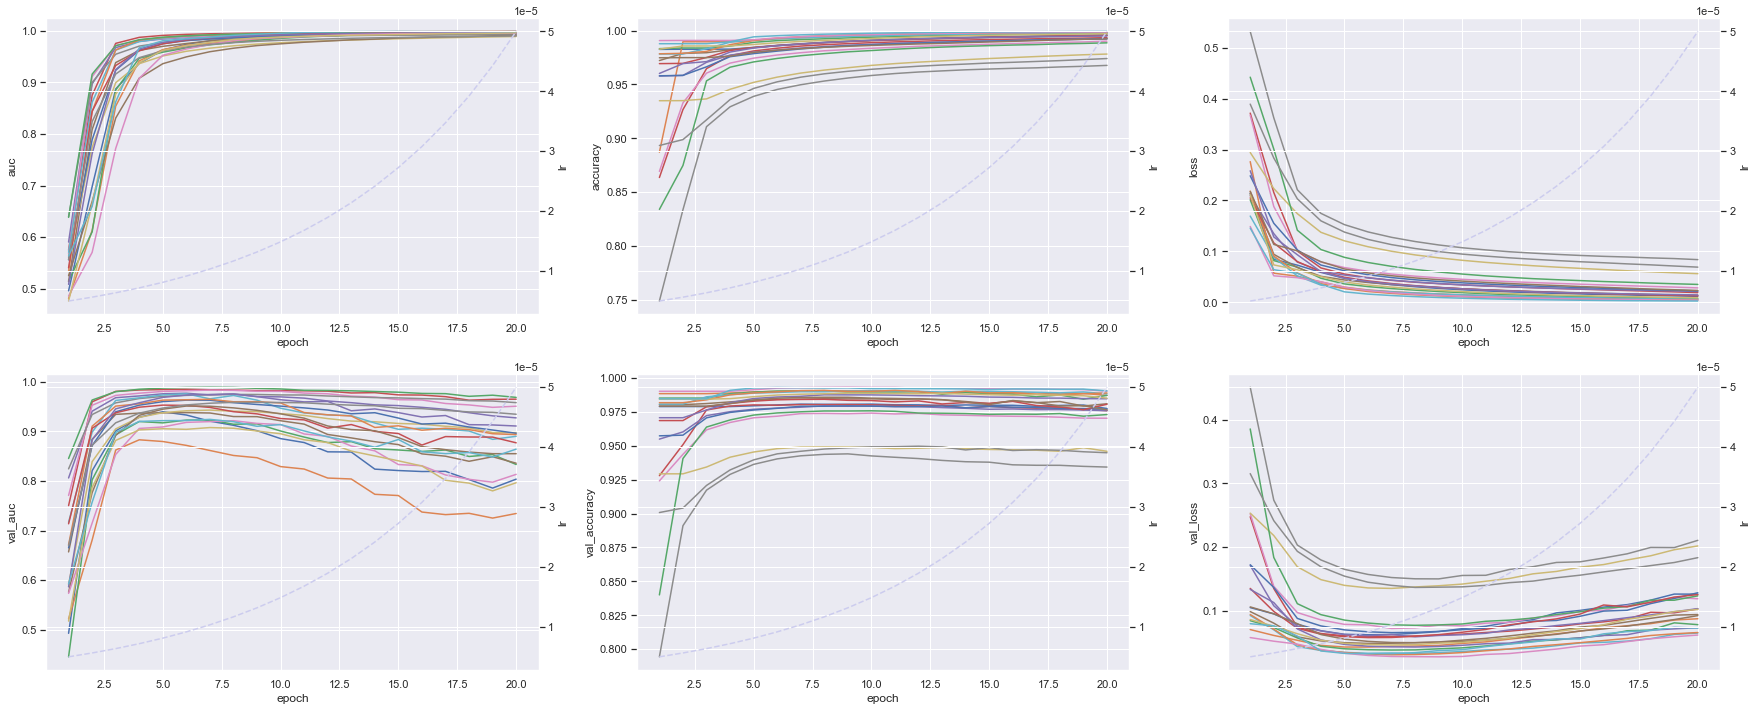

In [218]:
filters = 'model_lstm_onehot.*expanded'
plot_history(model_history(), filters, metrics=['auc','accuracy','loss'], width=3, height=2, tight=False, size=(30,12), val='separate')

In [282]:
make_confusion_matrix(onehot_pred_real_expanded, groups=cuisine_groups)

,brazilian,british,cajun_creole,chinese,filipino,french,greek,indian,irish,italian,jamaican,japanese,korean,mexican,moroccan,russian,southern_us,spanish,thai,vietnamese
0,82.134,2.423,0.119,0.095,1.187,0.201,0.000,0.380,0.665,0.379,0.579,0.108,0.000,0.823,0.000,0.500,1.181,1.541,0.102,0.000
1,1.737,57.027,0.991,0.057,2.176,5.046,1.282,1.518,10.976,0.690,1.738,0.865,0.000,0.054,0.000,15.000,4.657,0.487,0.137,0.199
2,0.496,0.808,80.056,0.000,0.989,2.249,0.481,0.000,0.000,0.906,0.000,0.000,0.000,0.560,0.000,9.000,6.383,1.541,0.000,0.000
3,0.496,3.069,0.040,83.143,8.704,0.494,0.000,0.542,0.111,0.758,0.464,7.950,11.847,0.226,0.077,1.000,0.727,0.324,2.220,5.373
4,0.744,0.323,0.952,0.705,64.787,0.292,0.000,0.217,0.000,0.291,0.116,1.731,3.310,0.127,0.000,2.000,0.493,0.081,1.469,4.776
5,0.000,5.170,1.705,0.876,0.000,59.726,2.778,0.832,12.084,5.080,1.159,2.380,0.000,0.271,0.921,3.500,3.386,6.164,0.000,0.100
6,0.000,0.000,0.278,0.000,0.000,1.133,80.556,0.940,0.000,1.407,0.000,0.379,0.000,0.118,1.842,0.500,0.960,2.757,0.000,0.000
7,0.496,0.485,0.079,0.057,1.583,0.859,0.053,81.020,0.554,0.108,1.854,0.270,0.000,0.904,9.286,0.000,0.493,1.460,0.102,0.000
8,0.000,5.493,1.150,0.019,0.198,4.059,0.000,0.127,60.643,0.514,0.348,0.108,0.000,0.190,1.381,0.000,1.232,0.487,0.000,0.000
9,0.000,7.108,3.608,0.000,0.000,12.121,5.983,1.085,2.993,83.380,1.043,0.162,0.087,1.094,4.375,4.000,4.022,6.407,0.000,0.000


#####
<p style="font-weight: 500; color: #556;">Let's look at the same dataset now and model for the multiclass case, for comparison:</p>

In [20]:
# multiclass - complete :)
model_wrapper_new(
    model_data_expanded, label = 'cuisine', model_name = 'model_lstm_expanded', lr = (5e-6, 1e-4), epochs = 20, split_epochs = True,
    batch_size = 512, epoch_subset = 1, rnn_depth = 64, embedding_dim = 32, layer_norm = True, multiclass = True
)

In [349]:
model_lstm_expanded_best = load_model('models/model_lstm_expanded_best')
model_lstm_expanded_best_preds = model_lstm_expanded_best.predict(model_data_expanded['val_data'][0], verbose=0)
best_preds_max = np.array([np.argmax(x) for x in model_lstm_expanded_best_preds])
pred_real_expanded = pd.concat([pd.DataFrame(np.array(best_preds_max)),pd.DataFrame(model_data_expanded['val_labels'])],axis=1)
pred_real_expanded.columns = ['pred','real']
pred_real_expanded['accuracy'] = pred_real_expanded.apply(lambda r: 1 if r['pred']==r['real'] else 0,axis=1)
print('Accuracy is: ',sum(pred_real_expanded['accuracy'])/len(pred_real_expanded),'\n')

Accuracy is: 0.767007079201336



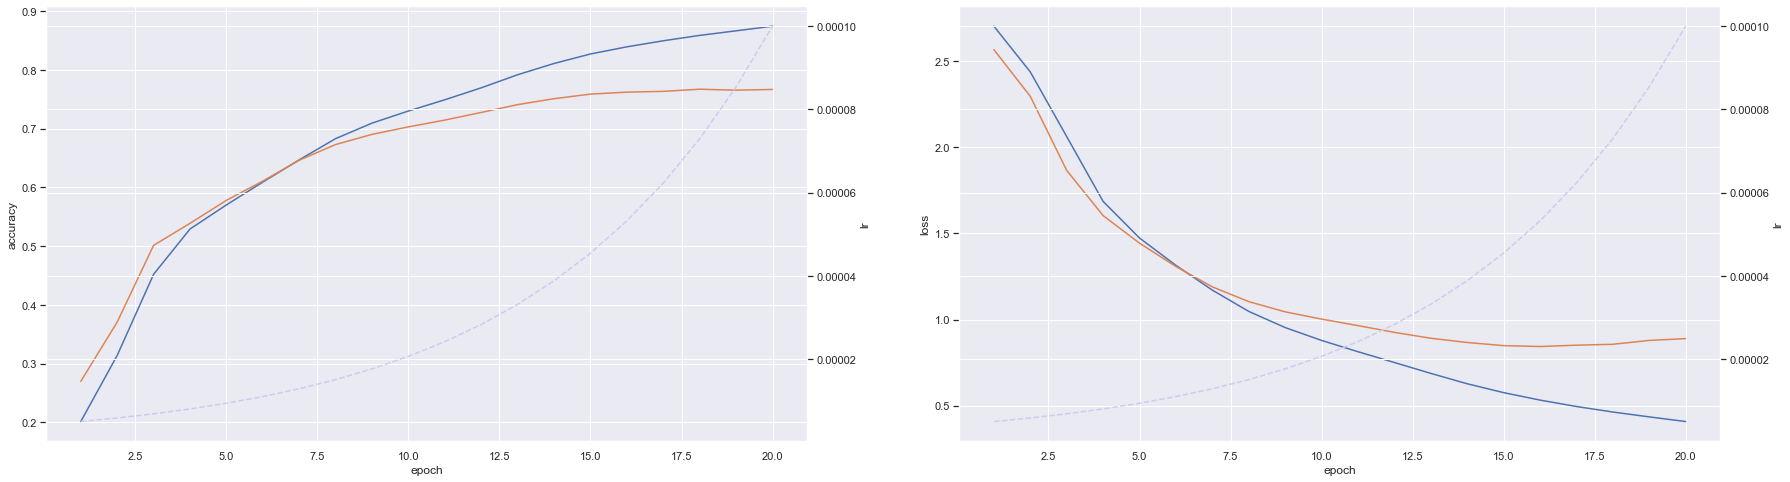

In [357]:
filters = '^model_lstm_expanded$'
plot_history(model_history(), filters, metrics=['accuracy','loss'], width=2, height=1, tight=False, size=(30,8), val='overlap')

In [296]:
make_confusion_matrix(preds_df_expanded, groups=cuisine_groups)

,brazilian,british,cajun_creole,chinese,filipino,french,greek,indian,irish,italian,jamaican,japanese,korean,mexican,moroccan,russian,southern_us,spanish,thai,vietnamese
0,49.891,0.798,2.326,0.058,3.520,0.320,0.000,0.417,1.558,0.136,1.891,0.412,0.000,0.981,0.000,0.673,1.297,1.322,0.194,0.598
1,1.532,48.902,0.701,0.000,0.550,4.236,0.797,0.645,8.782,0.401,4.202,0.618,1.355,0.243,2.275,9.865,4.335,0.278,0.517,0.085
2,1.532,0.798,76.154,0.078,1.430,2.617,0.697,0.000,0.000,0.695,0.630,0.000,0.000,0.657,0.000,1.121,5.501,2.644,0.000,0.512
3,0.000,0.798,0.074,82.882,9.681,0.960,0.000,0.265,0.000,0.451,0.000,8.810,14.056,0.153,0.000,0.897,0.773,0.000,4.654,8.198
4,2.845,0.998,0.775,1.694,57.866,0.226,0.000,0.171,0.000,0.072,0.000,1.958,1.863,0.450,0.000,4.484,0.851,0.278,1.390,6.917
5,0.000,11.577,1.366,0.818,0.000,57.605,2.590,1.062,10.057,5.482,1.681,2.267,0.000,0.441,1.787,17.713,3.615,7.029,0.000,0.085
6,0.000,0.000,1.255,0.000,0.000,1.675,69.821,1.441,0.000,2.078,0.000,0.000,0.000,0.090,1.543,3.139,0.301,1.948,0.000,0.427
7,1.313,0.898,0.148,0.039,0.660,1.130,0.847,82.578,4.249,0.079,0.945,3.503,0.254,0.819,6.824,0.000,0.524,1.322,1.972,0.171
8,0.000,15.669,0.074,0.097,0.000,2.993,0.548,0.019,67.989,0.566,0.525,0.000,0.169,0.189,2.112,0.224,1.323,0.905,0.000,0.000
9,0.219,0.200,3.175,0.643,0.000,15.154,13.596,1.062,1.700,84.728,0.420,0.721,0.000,2.161,1.706,2.691,5.029,9.255,0.162,0.598


<p style="font-weight: 500; color: #556;">We can see straight away, here, that we have a significant drop in performance for most of the groups.  Exceptions here are the Indian and Irish groups which actually preferred the multiclass approach, but generally we would, adn do, expect the binary set of models to be stronger, as we're asking for just a simgle data split each time.</p>

####
#### **TACKLING THE LEAST PREDICTIVE CLASSES**

<p style="font-weight: 500; color: #556;">The weakest groups remain English, Russian, Filipino, French, Thai, Vietnamese and Spanish.  These groups cannibalise each other to some extent, and we can carry out further analysis to help understand why</p>

####

####
#### **REGULARIZATION AND HYPERPARAMETER TUNING**

In [ ]:
embedding_dim = [8,16,32,64]
rnn_dim = [64,256,1024]
dropout = [0.0,0.2,0.4]
recurrent_dropout = [0.0,0.1,0.2,0.3,0.4,0.5]
kernel_regularizer = [0.0,0.1,0.2,0.3,0.4,0.5]
recurrent_regularizer = [None,'l1','l2','l1_l2']
bias_regularizer = [None,'l1','l2','l1_l2']
activity_regularizer = [None,'l1','l2','l1_l2']

In [ ]:
model_wrapper_new(
    model_data_expanded, label = 'cuisine', model_name = 'model_lstm_expanded', lr = (5e-6,1e-4), epochs = 7, split_epochs = True,
    batch_size = 512, epoch_subset = 1, rnn_depth = 64, embedding_dim = 32, layer_norm = True, multiclass = True
)

####
#### **ATTENTION-BASED METHODS (to do!)**

Lorem ipsum

####
#### **CONCLUSIONS**